In [10]:
## Main SWR detection analysis! Note there are two ways to analyze the data: a cluster and local version. I keep them
## both updated with changes for now since I tend to check with the local version even if the cluster version is better
## for bulk analysis 2020-6-17 JS
## Updated for catFR1 analysis 2020-09-29 JS. Largely edited for manually removing bad electrodes 
## (search for catFR1 in CLUSTER get for example)

# Paring down essentials for Ebrahim. JJS 2023-02-28 


In [11]:
import pandas as pd; pd.set_option('display.max_columns', 30); pd.set_option('display.max_rows', 100)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter, ResampleFilter, MorletWaveletFilter
import xarray as xarray
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
from scipy.stats import zscore
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/johnModules')
from brain_labels import HPC_labels, ENT_labels, PHC_labels, temporal_lobe_labels,\
                         MFG_labels, IFG_labels, nonHPC_MTL_labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *  

df = get_data_index("r1") # all RAM subjects
exp = 'catFR1' # 'FR1' 'catFR1' 'RepFR1'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# sub lists I've been using to explore FR1 

# subs = ['R1010J'] #'R1385E'] # ['R1065J'] #
# subs = ['R1002P','R1003P','R1006P','R1010J','R1112M','R1163T'] # initial 6 for hippocampus

# subs = subs+['R1001P','R1092J','R1151E','R1320D'] # additional subs with issues that I resolved with various RR and corr thresholds
# subs = ['R1112M','R1018P','R1020J','R1022J','R1023J','R1026D','R1027J'] # 7 with entorhinal
# subs = ['R1010J','R1112M'] # original 2 # R1108J beatiful catFR1 data; R1065J magical subject (like with FR1)
# subs = ['R1112M','R1163T'] # subjects with FR1 and catFR1. SRs of 1000 and 500 tho
# subs = ['R1151E'] # all channels X sessions get removed but 3 after 60/180 hz line removal
# these should all be worked out now. See SWR FR1 problem sessions PPT on Box for details of each
# subs = ['R1299T','R1332M','R1397D','R1349T','R1339D','R1337E','R1275D','R1151E','R1123C','R1120E','R1045E'] # final surrounding_recall problem subs after looking at huge raster!
# subs = ['R1308T','R1338T','R1358T'] # these guys had weird SRs and some loading problems when I went to whole_retrieval analysis...fixed with rounding
# subs = ['R1023J','R1101T','R1148P','R1368T','R1323T','R1334T'] # single session subs with memory allocation errors in ClusterRun
# subs = ['R1006P','R1010J','R1030J','R1032D','R1049J','R1051J','R1052E','R1054J','R1093J','R1098D','R1104D','R1108J','R1111M',
#         'R1115T','R1118N','R1124J','R1207J','R1230J','R1316T','R1329T','R1323T','R1337E','R1367D'] # subs that didn't load on 2020-07-04 encoding run
# subs = ['R1368T','R1461T','R1463E'] # subs with particularly low localization.pair matches in pairs...see Excel in loading info on Box for details
# subs = ['R1433E','R1355T','R1367D','R1368T'] # subs with "ca3" or "dg"
# subs = ['R1001P'] # subject with over 8000 FR1 trials X electrodes
# bad_subs = ['R1433E','R1051J'] # no electrode cats
# subs = ['R1379E','R1385E','R1387E','R1394E','R1402E'] # partial beep subs
# subs = ['R1379E','R1402E','R1396T','R1395M','R1415T','R1389J','R1404E']  # test subs for eeg offset correction
# subs = ['R1054J','R1345D','R1048E','R1328E','R1308T', # first 2 are sr ≥ 1000. 3rd is 500 Hz.
#         'R1137E','R1136N','R1094T','R1122E','R1385E', # nice example FR1 subs used in Fig. 2
#         'R1405E','R1486J','R1501J'] # adding in 3 catFR only patients that will go into Fig. 4
# subs = ['R1120E','R1349T','R1397D','R1332M','R1299T'] # FR1 patients with electrode search ranges limited per SWR problem sessions doc on Box
# subs = ['R1269E','R1328E','R1367D','R1397D','R1405E','R1405E','R1447M','R1469D'] # catFR1 patients with electrode search changes limited
# subs = ['R1065J','R1492J','R1525J'] # killer subs
# subs = ['R1030J','R1035M'] # MFG subs
subs = ['R1086M'] #'R1035M'] #['R1108J'] # R1065J # 'R1035M'
# subs = ['R1111M','R1108J','R1191J','R1229M','R1247P','R1264P','R1261P','R1016M','R1065J','R1191J',
#         'R1190P','R1254E','R1337E','R1118N','R1153T','R1156D'] # FR1 patients that are getting encoding memory errors 
# subs = ['R1051J','R1118N','R1154D','R1207J','R1308T','R1311T','R1329T','R1334T','R1336T','R1334T',
#         'R1342M','R1212P','R1346T','R1311T','R1323T','R1329T','R1342M','R1346T','R1367D','R1569T'] # catFR1 memory error patients

# subs = ['R1001P','R1002P','R1003P','R1006P','R1010J','R1018P','R1020J','R1022J', # mimicking test session
#         'R1023J','R1026D','R1027J','R1030J','R1031M','R1032D','R1033D','R1034D']
# subs = ['R1367D'] #['R1525J'] #['R1367D'] #R1065J'

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp) & (df.session==1)] # single session
# sub_df = df[(df.experiment == exp) & (df.session == 0)] # all FR subs 
# sub_df = sub_df[0:1]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
510,NaN,protocols/r1/subjects/R1086M/experiments/catFR...,protocols/r1/subjects/R1086M/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1086M/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1086M/localizations/0/m...,NaN,0,R1086M,R1086M,NaN,protocols/r1/subjects/R1086M/experiments/catFR...


In [17]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
if exp == 'FR1':
    exp_df = exp_df[
                    ((df.subject!='R1015J') | (df.session!=0)) & 
                    ((df.subject!='R1063C') | (df.session!=1)) & 
                    ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                    ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1120E') | (df.session!=0)) &
                    ((df.subject!='R1122E') | (df.session!=2)) &
                    ((df.subject!='R1154D') | (df.session!=0)) &
                    ((df.subject!='R1186P') | (df.session!=0)) &
                    ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                    ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1277J') | (df.session!=0)) &
                    ((df.subject!='R1413D') | (df.session!=0)) & 
                    ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                    ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                    ((df.subject!='R1275D') | (df.session!=3))  # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
    #                 (df.subject!='R1065J') # sub with 9000 trials
                   ] 
elif exp == 'catFR1': 
    exp_df = exp_df[
                    ((df.subject!='R1044J') | (df.session!=0)) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1491T') | (~df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1486J') | (~df.session.isin([4,5,6,7]))) & # repeated data...will be removed at some point... @@
                    ((df.subject!='R1501J') | (~df.session.isin([0,1,2,3,4,5]))) & # these weren't catFR1 (and they don't load right anyway)
                    ((df.subject!='R1235E') | (df.session!=0)) & # split EEG filenames error...documented on Asana
                    ((df.subject!='R1310J') | (df.session!=1)) & # session 1 is just a repeat of session 0
                    ((df.subject!='R1239E') | (df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
    ]
elif exp == 'RepFR1':
    exp_df = exp_df[
                    (df.subject!='R1564J') # clearly something wrong with these EEG when looking at ripple raster
                    ]
print(f"Experiment data frame shape: {exp_df.shape}")
# exp_df = exp_df[257:] # for catFR1 this is R1385E-onwwards
# exp_df = exp_df[472:] # for FR1 this is R1385E-onwwards
# exp_df = exp_df[468:] # for catFR1 this is R1525J-onwards
exp_df.head()

Experiment data frame shape: (564, 17)


/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
24,NaN,protocols/r1/subjects/R1004D/experiments/catFR...,protocols/r1/subjects/R1004D/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1004D/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1004D/localizations/0/m...,NaN,0,R1004D,R1004D,NaN,protocols/r1/subjects/R1004D/experiments/catFR...
45,NaN,protocols/r1/subjects/R1013E/experiments/catFR...,protocols/r1/subjects/R1013E/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1013E/experiments/catFR...,1,NaN,0,protocols/r1/subjects/R1013E/localizations/0/m...,NaN,0,R1013E,R1013E_1,NaN,protocols/r1/subjects/R1013E/experiments/catFR...
58,NaN,protocols/r1/subjects/R1015J/experiments/catFR...,protocols/r1/subjects/R1015J/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1015J/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1015J/localizations/0/m...,NaN,0,R1015J,R1015J,NaN,protocols/r1/subjects/R1015J/experiments/catFR...
64,NaN,protocols/r1/subjects/R1016M/experiments/catFR...,protocols/r1/subjects/R1016M/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1016M/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1016M/localizations/0/m...,NaN,0,R1016M,R1016M,NaN,protocols/r1/subjects/R1016M/experiments/catFR...
65,NaN,protocols/r1/subjects/R1016M/experiments/catFR...,protocols/r1/subjects/R1016M/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1016M/experiments/catFR...,0,NaN,1,protocols/r1/subjects/R1016M/localizations/0/m...,NaN,1,R1016M,R1016M,NaN,protocols/r1/subjects/R1016M/experiments/catFR...


In [16]:
# Want to try and find those files that haven't been made yet (due to memory limits) and re-run only those
# **only an issue with encoding or whole_retrieval due to their large EEG matrices**

### params that clusterRun used
selected_period = 'encoding' # surrounding_recall # whole_retrieval # encoding 
recall_type_switch = 0 # 0 for original, 1 for only those with subsequent, 2 for second recalls only, 3 for isolated recalls
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC #ENTPHC #AMY
remove_soz_ictal = 0
recall_minimum = 2000
filter_type = 'hamming'
extra = '' #'_no_param_removal' #-intrusions #'-ZERO_IRI'
###

# get strings for path name for save and loading cluster data
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

rerun_mask = []

for i,row in enumerate(exp_df.itertuples()):
    sub = row.subject; session = row.session; exp = row.experiment

    path_name = '/scratch/john/SWR_scratch/'+subfolder
    fn = os.path.join(path_name,
        'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                      '_'+soz_label+'_'+filter_type+extra+'.p') 
    try:
        with open(fn,'rb') as f:
            dat = pickle.load(f)
    except:
        rerun_mask.append(i)
        
# view the rerun_mask
len(rerun_mask)
rerun_df = exp_df.iloc[rerun_mask]
rerun_df.head()

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
24,NaN,protocols/r1/subjects/R1004D/experiments/catFR...,protocols/r1/subjects/R1004D/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1004D/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1004D/localizations/0/m...,NaN,0,R1004D,R1004D,NaN,protocols/r1/subjects/R1004D/experiments/catFR...
413,NaN,protocols/r1/subjects/R1067P/experiments/catFR...,protocols/r1/subjects/R1067P/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1067P/experiments/catFR...,0,NaN,1,protocols/r1/subjects/R1067P/localizations/0/m...,NaN,1,R1067P,R1067P,NaN,protocols/r1/subjects/R1067P/experiments/catFR...
747,NaN,protocols/r1/subjects/R1127P/experiments/catFR...,protocols/r1/subjects/R1127P/localizations/1/m...,catFR1,build,1,protocols/r1/subjects/R1127P/experiments/catFR...,2,NaN,0,protocols/r1/subjects/R1127P/localizations/1/m...,NaN,0,R1127P,R1127P_2,NaN,protocols/r1/subjects/R1127P/experiments/catFR...
838,NaN,protocols/r1/subjects/R1147P/experiments/catFR...,protocols/r1/subjects/R1147P/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1147P/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1147P/localizations/0/m...,NaN,0,R1147P,R1147P,2.0,protocols/r1/subjects/R1147P/experiments/catFR...
1071,NaN,protocols/r1/subjects/R1190P/experiments/catFR...,protocols/r1/subjects/R1190P/localizations/0/m...,catFR1,build,0,protocols/r1/subjects/R1190P/experiments/catFR...,0,NaN,0,protocols/r1/subjects/R1190P/localizations/0/m...,NaN,0,R1190P,R1190P,NaN,protocols/r1/subjects/R1190P/experiments/catFR...


## Load CLUSTER data

In [18]:
## Now to load data from cluster, have to go through and append across sessions

### params that clusterRun used (note that exp is defined in first cell so can get exp_df above)

selected_period = 'surrounding_recall'
# 'surrounding_recall': aligned to time of free recall 
# 'whole_retrieval': aligned to beginning of retrieval period (beep_off)
# 'encoding': aligned to word_on
# 'whole_encoding': aligned to 1st word of each encoding period and ends 29.7 s later (average time for 12 words to be shown)
#               NOTE: this analysis is in SWRanalysis-encoding.ipynb now
# 'math': aligned to math problem on
# 'math_retrieval': aligned to math problem key-in time

recall_type_switch = 0
    # (1 and 3 are basically opposites...those with a subsequent recall and those without)
    # 0: Original analysis taking only recalls without a recall in 2 s IRI before them
    # 1: Take these same recalls, but keep only those WITH a recall within 2 s after they occur 
    # 2: test condition where we look at second recalls within IRI ONLY (there is an initial recall in 2 s before current recall)
    # 3: isolatead recalls with no other recalls +/- RECALL_MINIMUM s
    # 4: only first recall of every retrieval period
    # 5: take only those recalls that come second in retrieval period within 2 s of first retrieval
    # 6: take only NOT first recall of every retrieval period (opposite of 4)
    # 7: take only NOT first recall AND ISOLATED trials (this should REALLY maximize SWR bump)
    # 8: take only 2nd recalls
    # 10: same as 0 but with no IRI (mostly just to see number of recalls)
recall_minimum = 2000 # used if recall_type_switch = 3
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC # TEMPORALLOBE # IFG # MFG
remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###
filter_type = 'hamming' # butter/hamming/hamming125200/tried hamming140250 for math
sub_selection = 'whole' # 'second_half', 'whole' ,'first_half'
                              # analyze first 40%, remaining 60% of data, or whole? 
                              # works for FR1 and catFR1
extra = '' # _no_param_removal # -ORIGNORMAN # -intrusions # '-ZERO_IRI'
###

# get strings for path name for save and loading cluster data
if recall_type_switch in [0,4,6,8]:
    # for these I'm using all trials, but selecting for which recall after the fact
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,0,selected_period,recall_minimum)
else: # these others I haven't set up indexing (see >line 100 in this cell)
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
ripple_array = []; HFA_array = []
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []; fr_array = []
list_num_key = []

serialpos_array = []; list_recall_num_array = []; # ~~~
rectime_array = []; recall_before_intrusion_array = []
recall_position_array = []; session_events = pd.DataFrame()

electrode_labels = []; channel_coords = []; channel_nums = []

analysis_df = getSplitDF(exp_df,sub_selection,exp)

for row in analysis_df.itertuples(): #analysis_df.itertuples(): #sub_df.itertuples():  
    try:
        sub = row.subject; session = row.session; exp = row.experiment

        path_name = '/scratch/john/SWR_scratch/'+subfolder
        if filter_type == 'butter':
            subfolder = 'IRIonly 2022-03-04 zscore events only HFA (and all other old files)' # this has the 'butter'
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                          '_'+soz_label+'_'+filter_type+extra+'.p') #'-NOCUTOFFS.p') #'_no_param_removal.p')   #'.p') #+'.intrusions.p') # +'.-wrong.p') (for wrong math)
                        # -NOCUTOFFS for Vaz filter for Norman/Staresina comparison
        with open(fn,'rb') as f:
            dat = pickle.load(f)

            ripple_array = superVstack(ripple_array,dat['ripple_array'])
#             HFA_array = superVstack(HFA_array,dat['HFA_array'])
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.extend(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            #,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)
            if selected_period == 'whole_retrieval':
                if np.shape(dat['fr_array'])[0]!=np.shape(dat['ripple_array'])[0]:
                    print(sub+str(session))
                fr_array = superVstack(fr_array,dat['fr_array'])
            elif selected_period == 'encoding':
                serialpos_array.extend(dat['serialpos_array'])
                session_events = session_events.append(dat['session_events']) # doesn't append in place 
            elif selected_period == 'surrounding_recall': # ~~~
                serialpos_array.extend(dat['serialpos_array']); list_recall_num_array.extend(dat['list_recall_num_array']); # ~~
                rectime_array.extend(dat['rectime_array']); recall_before_intrusion_array.extend(dat['recall_before_intrusion_array'])
                recall_position_array.extend(dat['recall_position_array'])
                               
            elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
                rectime_array.extend(dat['rectime_array'])
                recall_position_array.extend(dat['recall_position_array']); list_recall_num_array.extend(dat['list_recall_num_array'])
            elif selected_period == 'whole_encoding':
                serialpos_array.extend(dat['serialpos_array']); recall_position_array.extend(dat['recall_position_array'])
                list_recall_num_array.extend(dat['list_recall_num_array']); 

            electrode_labels.extend(dat['electrode_labels'])
            channel_coords.extend(dat['channel_coords'])
            channel_nums.extend(dat['channel_nums'])
            list_num_key.extend(dat['list_num_key'])
            
    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')  
print('**Done reading data**')
        
## loading *all* the recalls with 0, but if it's 4 or 6 load just those trials

# trying new method of loading...translate these to ripple_array length dependent on recall_type_switch 
# (this way I can always load from recall_type_switch = 0)

subject_name_array,session_name_array,electrode_array,channel_coords_array,channel_nums_array = getSubSessPredictorsWithChannelNums(
        sub_names,sub_sess_names,trial_nums,electrode_labels,channel_coords,channel_nums)

if selected_period == 'surrounding_recall':
    if recall_type_switch == 4:
        temp_recall_idxs = np.array(recall_position_array)==1
    elif recall_type_switch == 6:
        temp_recall_idxs = np.array(recall_position_array)>1
    elif recall_type_switch == 8:
        temp_recall_idxs = np.array(recall_position_array)==2
    else:
        temp_recall_idxs = np.array(recall_position_array)>=0
    serialpos_array = np.array(serialpos_array)[temp_recall_idxs]
    recall_before_intrusion_array = np.array(recall_before_intrusion_array)[temp_recall_idxs]
    list_num_key = np.array(list_num_key)[temp_recall_idxs]
elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
    temp_recall_idxs = np.array(recall_position_array)>=0 # just keep them all for math
    encoded_word_key_array.extend(dat['encoded_word_key_array'])
elif selected_period == 'whole_encoding':
    temp_recall_idxs = np.array(list_recall_num_array)>=0 # just keep them all
elif selected_period == 'encoding':
    print('There is a separate program for loading encoding dumb guy!')
    session_events = session_events[temp_recall_idxs]
    
subject_name_array = np.array(subject_name_array)[temp_recall_idxs]
session_name_array = np.array(session_name_array)[temp_recall_idxs]
electrode_array = np.array(electrode_array)[temp_recall_idxs]
channel_coords_array = np.array(channel_coords_array)[temp_recall_idxs]
channel_nums_array = np.array(channel_nums_array)[temp_recall_idxs]
ripple_array = np.array(ripple_array)[temp_recall_idxs]
# HFA_array = np.array(HFA_array)[temp_recall_idxs]

rectime_array = np.array(rectime_array)[temp_recall_idxs]
list_recall_num_array = np.array(list_recall_num_array)[temp_recall_idxs]
recall_position_array = np.array(recall_position_array)[temp_recall_idxs]
    
print('**Done translating to ripple_array frame**!!')
print('...')
print('% of all HPC subjects for '+exp)
if exp == 'catFR1':
    len(np.unique(sub_names))/136*100 # % HPC subs for catFR1
    print('% of HPC recalls for '+exp)
    ripple_array.shape[0]/50053*100 # % recalls for catFR1
if exp == 'FR1':
    len(np.unique(sub_names))/167*100 # % HPC subs for FR1
    print('% of HPC recalls for '+exp)
    ripple_array.shape[0]/60417*100 # % recalls for FR1
    
## some info on data loaded from cluster runs ##
ripple_array.shape

region_electrode_ct = np.array(region_electrode_ct)
# print('Number of electrodes in each session: '); region_electrode_ct
print('From '+str(sum(region_electrode_ct>0))+'/'+str(len(region_electrode_ct))+' sessions with >0 '+region_name+' electrodes')
print('Total trials: '+str(int(np.sum(trial_nums))))
print('Unique sessions: '+str(len(np.unique(sub_sess_names))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')

# some info about regions 
sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))

print('Electrode regions X sessions:')
unique_names = np.unique(HPC_names)
for name in unique_names:
    num_elecs = sum(np.array([names.find(name) for names in HPC_names])>=0)
    print(str(num_elecs)+' for '+name)


[]
[]
2023-03-08_11-00-40: DF Exception: Sub: R1102P, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_catFR1_R1102P_0_HPC_surrounding_recall_soz_in_hamming.p', file: <ipython-input-18-7f82adbf0b6b>, line no: 70
2023-03-08_11-00-41: DF Exception: Sub: R1147P, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_catFR1_R1147P_0_HPC_surrounding_recall_soz_in_hamming.p', file: <ipython-input-18-7f82adbf0b6b>, line no: 70
2023-03-08_11-00-42: DF Exception: Sub: R1176M, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_catFR1_R1176M_0_HPC_surrounding_recall_soz_in_hamming.p', file: <ipython-input-18-7f82adbf0b6b>, line no: 70
2023-03-08_11-00-44: DF Exception: Sub: R1254E, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/IRIonly/SWR_catFR1_R1254E_0_HPC_surrounding_recall_soz_in_hamming.p', f

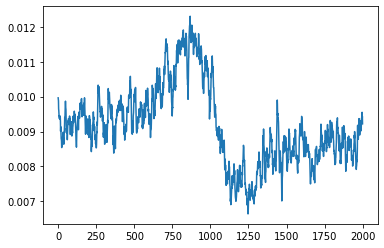

In [19]:
np.shape(ripple_array)
plot(np.mean(ripple_array,0)); show()
# np.shape(HFA_array)
# plot(np.mean(HFA_array,0)); show()


## LOCAL run (original program)

In [20]:
import mne
from scipy.signal import firwin,filtfilt,kaiserord
import pingouin as pg
%autoreload

### PARAMS ###

save_values = 0

selected_period = 'encoding' 
# 'surrounding_recall': aligned to time of free recall 
# 'whole_retrieval': aligned to beginning of retrieval period (beep_off)
# 'encoding': aligned to word_on 
# 'whole_encoding': aligned to 1st word of each encoding period and ends 29.7 s later (average time for 12 words to be shown)
# 'math': aligned to math problem on
# 'math_retrieval': aligned to math problem key-in time

# there are three periods this code is set up to look at: periods aligned to recall, the entire retrieval period, and the encoding period
recall_type_switch = 0 # how do we select recalls?? Numbers 0:3
# 0: Original analysis taking only recalls without a recall in 2 s IRI before them
# 1: Take these same recalls, but keep only those WITH a recall within 2 s after they occur
# 2: test condition where we look at second recalls within IRI ONLY
# 3: ISOLATED only!
# 4: only first recall of every retrieval period
# 5: take only those recalls that come second in retrieval period within 2 s of first retrieval
# 6: take only NOT first recall of every retrieval period
# 7: take only NOT first recall AND ISOLATED trials (this should REALLY maximize SWR bump)
# 10: same as 0 but with no IRI (mostly just to see number of recalls)

selected_region = HPC_labels #HPC_labels # ENT_labels+HPC_labels

remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###

min_ripple_rate = 0.1 # Hz. # 0.1 for hamming
max_ripple_rate = 1.5 # Hz. # 1.5 for hamming
max_trial_by_trial_correlation = 0.05 # if ripples correlated more than this remove them # 0.05 for hamming
max_electrode_by_electrode_correlation = 0.2 #??? # 0.2 for hamming

filter_type = 'hamming' # see local version below for details 
# butter (Vaz algorithm)
# hamming (Norman algorithm)
# hamming125200 (Norman algorithm meant to capture "true" ripple frequency per Sullivan...Buzsaki 2011
# hamming140250 (Same idea, but higher bands)
# staresina (Staresina et al 2015 NatNeuro)

# Additional details: 
# •Vaz used Butterworth from 80-120 Hz; Norman used Hamming from 70-180 Hz
# •Butterworth from Vaz et al: 2nd order from 80-120 ms, hilbert, select events >2 STD above mean of filtered traces.
#      Events >=25 ms long w/ max amp >3 SD were retained as ripples. Join adjacent ripples separated by <15 ms 
# •Hilbert from Norman et al: "70-180 Hz zero-lag linear-phase Hamming FIR filter w/ transition bandwidth of 5 Hz"
#      Then Hilbert, clip extreme to 4 SD, square this clipped, smooth w/ Kaiser FIR low-pass filter with 40 Hz cutoff,
#      mean and SD computed across entire experimental duration to define the threshold for event detection
#      Events from original (squared but unclipped) signal >4 SD above baseline were selected as candidate SWR events. 
#      Duration expanded until ripple power <2 SD. Events <20 ms or >200 ms excluded. Adjacent events <30 ms separation (peak-to-peak) merged.
# •Using IED detection from Vaz for 250 Hz highpass events (really 250-499). Norman uses 20-60 Hz events which is...odd.
#       See detectRipples code in module for this algorithm


# recall params
recall_minimum = 2000
IRI = 2000 # inter-ripple interval...remove ripples within this range (keep only first one and remove those after it)
retrieval_whole_time = 30000
# encoding params
encoding_whole_time = 1000*np.round(12*(1.6+0.875),1) # 0.875 is average of 0.75-1.0 s so 29.7 is average encoding length
encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700 # since minimum ISI is 0.75 s let's only plot the 500 ms before word on with a 200 ms buffer
# these aren't likely to be changed:
desired_sample_rate = 500. # in Hz. This seems like lowerst common denominator recording freq.
eeg_buffer = 300 # buffer to add to either end of IRI when processing eeg #**

# soz_keep = [0,1] # 0 are good elecs and 1 are SOZ elecs. Never keep 2 (bad leads) ###
# if remove_soz_ictal == 1:
#     soz_keep = [0]
# elif remove_soz_ictal == 2:
#     soz_keep = [1]

### END PARAMS ###

# get region label
if selected_region == HPC_labels:
    region_name = 'HPC'
elif selected_region == ENT_labels:
    region_name = 'ENT'
elif selected_region == PHC_labels:
    region_name = 'PHC'
elif selected_region == temporal_lobe_labels:
    region_name = 'TEMPORALLOBE'
elif selected_region == MFG_labels:
    region_name = 'MFG'
elif selected_region == IFG_labels:
    region_name = 'IFG'
elif selected_region == nonHPC_MTL_labels:
    region_name = 'nonHPC_MTL'    

# analysis period
if selected_period == 'surrounding_recall':
    psth_start = -IRI # only makes sense to look at period <= IRI
    psth_end = IRI # how long to grab data after recall
elif selected_period == 'whole_retrieval':
    psth_start = -IRI # doesn't have to be IRI just 2000 ms is convenient
    psth_end = IRI+retrieval_whole_time
elif selected_period == 'whole_encoding':
    psth_start = -2000
    psth_end = encoding_whole_time    
elif selected_period == 'encoding':
    psth_start = pre_encoding_time
    psth_end = encoding_time
elif selected_period == 'whole_encoding':
    psth_start = -2000
    psth_end = 2000
elif (selected_period == 'math') | (selected_period == 'math_retrieval'): #$$
    psth_start = -2000 # just use 2000 since math problems are actually like 5 s apart typically
    psth_end = 2000   

ripple_array = []; fr_array = []; HFA_array = []
trial_nums = []; 
session_ct = 0; channel_ct = 0; total_channel_ct = 0
HPC_names = []; sub_names = []; sub_sess_names = []
electrodes_per_session = []
total_lists = 0; total_recalls = 0; kept_recalls = 0
align_adjust = 0
ent_elec_ct = []; sd_regions = []; not_sd_regions = []
ripple_ied_accum_ct = []
time_add_save = [];             
encoded_word_key_array = []
list_num_key = []

list_recall_num_array = []; rectime_array = []; recall_before_intrusion_array = [] # new ones added 2020-11-24
serialpos_array = [] # used to be encoding info but commandeered for surrounding_recalls ~~~
recall_position_array = []; recall_index_array = []
session_events = pd.DataFrame()

trial_by_trial_correlation = []; elec_by_elec_correlation = []
elec_ripple_rate_array = []

channel_coords = []; electrode_labels = []; channel_nums = []

for row in sub_df.itertuples(): #sub_df.itertuples():   
    try:
        sub = row.subject; session = row.session; exp = row.experiment
        mont = int(row.montage); loc = int(row.localization)
        reader = CMLReadDFRow(row)
        evs = reader.load('task_events')
        # 1) change evs.recalled to False 2) comment out nonrepeat_indicator>0 for good_recalls = (or it removes all the -1s) 
        # 3) set getOutputPositions to [] 4) change save name at bottom to '_intrusions.p'
        if exp == 'RepFR1':
            evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.intrusion==0)]
        else:
            evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.recalled==True)] # recalled word AND correct (from this list...False for instrusions).        
        word_evs = evs[evs['type']=='WORD'] # get words 

        # select which recalls??         
        [recall_selection_name,selected_recalls_idxs] = selectRecallType(recall_type_switch,evs_free_recall,IRI,recall_minimum)
        
        _,nonrepeat_indicator = removeRepeatedRecalls(evs_free_recall,word_evs) # remove free recalls that happened more than once
        
        # let's make sure remaining recalls are not repeated, have eeg, and are not from non-practice lists (practice is -1 in FR1/catFR1 and 0 in RepFR1)
        good_recalls = selected_recalls_idxs & np.array(evs_free_recall.eegoffset>-1) & np.array(evs_free_recall.list > 0) & (nonrepeat_indicator>0) ##^
        evs_free_recall = evs_free_recall[good_recalls]

        # get temp key of recalls that lead to intrusions ~~~
        pre_intrusion_recalls = getRecallsBeforeIntrusions(evs,evs_free_recall)

        if len(evs_free_recall)==0: #...and that any are left!
            continue

        # get output position in each list for this session's recalls
        session_corrected_list_ops = getOutputPositions(evs,evs_free_recall)
            
        pairs = reader.load('pairs')
        try:
            localizations = reader.load('localization')
        except:
            localizations = []
        tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
        elec_regions,atlas_type,pair_number,has_stein_das = get_elec_regions(localizations,pairs) 

#         # count elec regions with specific string...mostly here to comment out below and test for good sessions
#         if len(findAinB(ENT_labels,elec_regions))>0:
#             ent_ct = len(findAinB(ENT_labels,elec_regions))
#             ent_elec_ct = np.append(ent_elec_ct,sub+'_'+str(session)+'_ct-'+str(ent_ct))

        # load eeg
        if selected_period == 'surrounding_recall':
            total_recalls = total_recalls + len(evs_free_recall) # get total recalls from lists
            total_lists = total_lists + len(evs[evs.type=='WORD'].list.unique()) # get total lists
            kept_recalls = kept_recalls + len(evs_free_recall)
            eeg_events = evs_free_recall
            
            # fix EEG offset due to Unity implementation error @@
    #         init_time = eeg_events.iloc[0].eegoffset
            eeg_events = correctEEGoffset(sub,session,exp,reader,eeg_events)
    #         print(sub+'-'+str(session)+'-'+exp+': '+str(eeg_events.iloc[0].eegoffset-init_time))
            
        elif selected_period == 'whole_retrieval':
            # grab whole retrieval periods for a better baseline of SWRs
            evs_rets = evs[evs.type=='REC_START']
            evs_rets = evs_rets[evs_rets.list>-1] # remove practice lists
            evs_rets = evs_rets[evs_rets.eegoffset>-1] # any trial with no eeg gets removed by cmlreaders so it's not in ripple_array 
            eeg_events = evs_rets
            
            # get alignmnet of end of beep time to EEG so can align retrieval to end of beep across all sessions
            align_adjust = getRetrievalStartAlignmentCorrection(sub,session,exp) # in ms
            
        elif selected_period == 'whole_encoding':
            # grab whole encoding periods to assess lists with more ripples
            evs_enc = evs[evs.list > -1] # remove practice lists **            
            evs_enc = evs_enc[evs_enc.eegoffset > -1] # any trial with no eeg gets removed by cmlreaders so it's not in ripple_array 

            # beginning of encoding doesn't have a consistent code, and the last consistent one before it is COUNTDOWN_END, so search for 1st WORD after each
            
            # gotta do this for each individually since it's not a consistent offset across lists (e.g. sometimes COUNTDOWN_END shows up after ORIENT_START)
            countdown_idxs = findInd(evs_enc.type=='COUNTDOWN_END')
            first_word_idxs = []
            for countdown_idx in countdown_idxs:
                got_words = 0
                next_type = 1
                while got_words == 0:
                    if (countdown_idx+next_type)<len(evs_enc):
                        # if you find a WORD, align all the events to this index to get the encoding_starts
                        if evs_enc.iloc[countdown_idx+next_type].type == 'WORD':
                            first_word_idxs.append(countdown_idx+next_type)
                            # reset values
                            got_words = 1
                            next_type = 1                    
                        else:
                            next_type+=1
                    else: # sometimes patients stop working after countdown, so if that happens just get out of while loop and you're done!
                        got_words = 1
                        next_type = 1
            
            eeg_events = evs_enc.iloc[first_word_idxs]           
            
        elif selected_period == 'encoding':
            ## apparently there are repeated words?? should add program to check and remove
            # I'm going to save encoding word events too, but need a mask to keep track of:
            # 0) words not recalled 1) words recalled from this list 2) words later recalled BUT IRI<2 s so removed
            evs_encoding_words = evs[evs.type=='WORD']
            evs_encoding_words = evs_encoding_words[evs_encoding_words.list>-1]            
            evs_encoding_words = evs_encoding_words[evs_encoding_words.eegoffset>-1]
            encoded_word_key = np.zeros(len(evs_encoding_words)) # 0 for not recalled
            encoded_word_key[evs_encoding_words.recalled==True] = 2 # 2 for recalled but removed bc IRI<2 s
            encoded_word_key[evs_encoding_words.item_name.isin(evs_free_recall.item_name.unique())] = 1 # recalled words
            # since finding all encoding words IN the list of correctly free recalled words won't have any intrusions
            eeg_events = evs_encoding_words

        elif (selected_period == 'math') | (selected_period == 'math_retrieval'): #$$
            
            evs_math = reader.load('all_events')
            evs_math = evs_math[(evs_math.type=='PROB')]

            # select which recalls??         
            [recall_selection_name,selected_recalls_idxs] = selectRecallType(recall_type_switch,evs_math,IRI,recall_minimum)

            # let's make sure remaining recalls are not repeated, have eeg, and are not from non-practice lists
            good_recalls = selected_recalls_idxs & np.array(evs_math.eegoffset>-1) & np.array(evs_math.list > -1) & np.array(evs_math.iscorrect==1)
            evs_math = evs_math[good_recalls]
            eeg_events = copy(evs_math) #$$
            
            if selected_period == 'math_retrieval': #$$
                temp_eeg = reader.load_eeg(events=eeg_events, rel_start=0, rel_stop=100) # just to get sampling rate
                sr = temp_eeg.samplerate
                sr_factor = 1000/sr
                eeg_events.mstime = eeg_events.mstime+eeg_events.rectime # align to retrieval key-in times...although I don't think this is actually used again?
                eeg_events.eegoffset = eeg_events.eegoffset+[int(v) for v in np.round(eeg_events.rectime/sr_factor).values] # this is only one that matters for aligning to EEG 
                # positive means looking at EEG into the future (when rectime happens)

        # fixing bad trials
        if sub == 'R1045E' and exp=='FR1': # this one session has issues in eeg trials past these points so remove events
            if selected_period == 'surrounding_recall':
                eeg_events = eeg_events.iloc[:65,:] # only the first 66 recalls have good eeg
            elif selected_period == 'whole_retrieval':
                eeg_events = eeg_events.iloc[:20,:] # only the first 20 retrieval periods have good eeg
            elif selected_period == 'encoding':
                eeg_events = eeg_events.iloc[:263,:] # same idea
                encoded_word_key = encoded_word_key[:263]
            elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
                eeg_events = [] #$$

        eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start-eeg_buffer+align_adjust, 
                              rel_stop=psth_end+eeg_buffer+align_adjust, clean=True, scheme=pairs) #**
        # event X channel X time
#         import ipdb; ipdb.set_trace()

        sr = eeg.samplerate
        
        # If using Vaz algo can't do >250 Hz IED detection so don't use this sub
        if (sr<990) and filter_type=='butter': #^^^
            print('Cannot use '+sub+' since using Vaz algo and sr ≤ 500!')
            continue        

        # if weird samplerate, add a few ms to make the load work
        if (499<sr<500) | (998<sr<1000):
            time_add = 1
            if (499<sr<500):
                sr = 500
            elif (998<sr<1000):
                sr = 1000
            while eeg.shape[2] < (psth_end-psth_start+2*eeg_buffer)/(1000/sr):
                eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start-eeg_buffer+align_adjust, 
                                      rel_stop=psth_end+eeg_buffer+time_add+align_adjust, clean=True, scheme=pairs)
                if time_add>50: #**
                    continue
                time_add+=1
            time_add_save.append(time_add)
            eeg.samplerate = sr # need to overwrite those that were just fixed

        eeg_ptsa = eeg.to_ptsa()
        eeg = None # clear variable
#         break;break;break # to look at eeg_ptsa (plots at bottom of notebook) before filtering

        # if we're doing big period like encoding, split in half by electrodes
        # so don't run out of memory
        if (selected_period == 'whole_encoding') | (selected_period == 'whole_retrieval'):
            half_elec = int(np.shape(eeg_ptsa)[1]/2)
            eeg_ptsa1 = ButterworthFilter(timeseries=eeg_ptsa[:,:half_elec,:], freq_range=[58.,62.], filt_type='stop', order=4).filter()
            eeg_ptsa1 = ButterworthFilter(timeseries=eeg_ptsa1, freq_range=[178.,182.], filt_type='stop', order=4).filter()
            eeg_ptsa2 = ButterworthFilter(timeseries=eeg_ptsa[:,half_elec:,:], freq_range=[58.,62.], filt_type='stop', order=4).filter()
            eeg_ptsa2 = ButterworthFilter(timeseries=eeg_ptsa2, freq_range=[178.,182.], filt_type='stop', order=4).filter()
            eeg_ptsa = eeg_ptsa1.append(eeg_ptsa2,'channel')
        else:
            # line removal...don't do 120 for now (I never see any line noise there for whatever reason)
            eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
            eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[178.,182.], filt_type='stop', order=4).filter()
            
        # let's save HFA too
        HFA_freqs = np.logspace(np.log10(64),np.log10(178),10)
        HFA_eeg = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[118.,122.], filt_type='stop', order=4).filter()
        HFA_eeg = ButterworthFilter(timeseries=HFA_eeg, freq_range=0.5, filt_type='highpass',order=4).filter() 
        HFA_morlet = MorletWaveletFilter(timeseries=HFA_eeg, freqs=HFA_freqs, output='power', width=5, verbose=True).filter()

        # now can remove buffers
        sr_factor = 1000/sr
        HFA_morlet = HFA_morlet[:,:,:,int(eeg_buffer/sr_factor):int(np.shape(HFA_morlet)[3]-(eeg_buffer/sr_factor))]
        HFA_morlet = xarray.ufuncs.log10(HFA_morlet, out=HFA_morlet.values)
        # resample down to 10 Hz (100 ms bins)

        HFA_morlet = ResampleFilter(timeseries=HFA_morlet,resamplerate=10).filter() # axes are freqs (10) X words X pairs X bins after downsample
#         # zscore across events & time bins # doing it differently now after talking to Mike 2022-03-08
#         HFA_morlet = (HFA_morlet - np.mean(HFA_morlet, axis=(1,3))) / np.std(HFA_morlet, axis=(1,3)) 
        # z-score using std of time bin averaged instead (mean is same either way)
        HFA_morlet = (HFA_morlet - np.mean(HFA_morlet, axis=(1,3))) / np.std(np.mean(HFA_morlet, axis=3),axis=1)
        HFA_morlet = np.mean(HFA_morlet,0) # mean over the 10 frequencies (now down to events X pairs X 100 ms bins)
                
        ## FILTERS ##
        trans_width = 5. # Width of transition region, normalized so that 1 corresponds to pi radians/sample. 
        # That is, the frequency is expressed as a fraction of the Nyquist frequency.
        ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(sr/trans_width) # gives 400 with sr=500, trans=5
        # formula from Belanger's Digital Processing of Signals
        # see https://dsp.stackexchange.com/questions/31066/how-many-taps-does-an-fir-filter-need for how to use
        
        if sr == 512 or sr == 1024 or sr == 1023.999: # last one fixes R1221P @@
            ntaps = np.ceil(ntaps)
        nyquist = sr/2        
    
        
        # filter for ripples using filter selected above
        if filter_type == 'hamming':
            # need to subtract out to get the filtered signal since default is bandstop but want to keep it as PTSA  
            FIR_bandstop = firwin(int(ntaps+1), [70.,178.], fs=sr, window='hamming',pass_zero='bandstop')               
            #         eeg_rip_band = filtfilt(FIR_bandpass,1.,eeg_ptsa) # can't use ptsa_to_mne this way so use eeg minus bandstopped signal            
            eeg_rip_band = eeg_ptsa-filtfilt(FIR_bandstop,1.,eeg_ptsa) 
            bandstop_25_60 = firwin(int(ntaps+1), [20.,58.], fs=sr, window='hamming',pass_zero='bandstop') # Norman 2019 IED            
            eeg_ied_band = eeg_ptsa-filtfilt(bandstop_25_60,1.,eeg_ptsa)
            ntaps40, beta40 = kaiserord(40, trans_width/nyquist)
            kaiser_40lp_filter = firwin(ntaps40, cutoff=40, window=('kaiser', beta40), scale=False, nyq=nyquist, pass_zero='lowpass')            
        elif filter_type == 'butter':
            eeg_rip_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[80.,120.], filt_type='bandpass',order=2).filter()
#             if sr == 500: # dropped below 250 Hz because too close Nyquist
#                 eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=250., filt_type='highpass',order=2).filter() 
#             elif sr >= 1000:    
#                 #this seems okay since large range far from Nyquist...problem is it likely misses key events
            eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[250.,490.], filt_type='bandpass',order=2).filter() #^^^
            eeg_raw = ptsa_to_mne(eeg_ptsa,[0,psth_end-psth_start+2*eeg_buffer])    #**  
#         eeg_ptsa = None # clear variable # no reason to do this in local version...really for cluster
        elif filter_type == 'staresina':
            FIR_bandstop_star = firwin(241, [80.,100.], fs=sr, window='hamming',pass_zero='bandstop') # order = 3*80+1               
            eeg_rip_band = eeg_ptsa-filtfilt(FIR_bandstop_star,1.,eeg_ptsa)
        
        if filter_type is not 'staresina':
            eeg_rip_band = ptsa_to_mne(eeg_rip_band,[0,psth_end-psth_start+2*eeg_buffer]) #** 
            _ = eeg_rip_band.apply_hilbert(envelope=True)
            eeg_ied_band = ptsa_to_mne(eeg_ied_band,[0,psth_end-psth_start+2*eeg_buffer]) #** 
            _ = eeg_ied_band.apply_hilbert(envelope=True)
            
        # get bad channel mask
        try:
            elec_cats = reader.load('electrode_categories') # this is cool
        except:
            if remove_soz_ictal == 1: # if no electrode_categories file then don't consisder this patient
                e = 'No electrode categories for '+sub+', session '+str(session)
                LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
                continue
            else:
                elec_cats = []

        bad_bp_mask = getBadChannels(tal_struct,elec_cats,remove_soz_ictal)

        # print(bad_bp_mask)
        electrode_search_range = getElectrodeRanges(elec_regions,exp,sub,session,mont)
        
        region_electrode_ct = 0
        session_ripple_rate_by_elec = []

        for channel in electrode_search_range:

            if (elec_regions[channel] in selected_region) & \
            (bad_bp_mask[channel] == 0): # selecting for SOZ or not ###
                
                total_channel_ct+=1 # total channels before artifact removal
                
                if filter_type != 'staresina':
                    # get data from MNE container 
                    eeg_rip = eeg_rip_band.get_data()[:,channel,:]     
                    eeg_ied = eeg_ied_band.get_data()[:,channel,:]
                else:
                    eeg_rip = eeg_rip_band[:,channel,:] # filtered signal still in PTSA format
                    

                # select detection algorithm (note that iedlogic is same for both so always run that)
                if filter_type == 'hamming':
                    # filter IEDs 
                    eeg_ied = eeg_ied**2 # already rectified now square
                    eeg_ied = filtfilt(kaiser_40lp_filter,1.,eeg_ied) # low pass filter  
                    mean1 = np.mean(eeg_ied)
                    std1 = np.std(eeg_ied)
                    iedlogic = eeg_ied>=mean1+4*std1 # Norman et al 2018            
                    # detect ripples
                    ripplelogic = detectRipplesHamming(eeg_rip,trans_width,sr,iedlogic)
                elif filter_type == 'butter':
                    eeg_mne = eeg_raw.get_data()[:,channel,:]
                    # detect ripples
                    ripplelogic, iedlogic = detectRipplesButter(eeg_rip,eeg_ied,eeg_mne,sr)    
                elif filter_type == 'staresina':
                    ripplelogic = detectRipplesStaresina(eeg_rip,sr)

                if filter_type == 'butter': # ^^^
                    desired_sample_rate = 1000 # for Vaz algo

                if sr>desired_sample_rate: # downsampling here for anything greater than 500 (hamming) or 1000 (butter)
                    ripplelogic = downsampleBinary(ripplelogic,sr/desired_sample_rate)
            
                # ripples are detected, so can remove buffers now #**
                ripplelogic = ripplelogic[:,int(eeg_buffer/(1000/desired_sample_rate)):
                                          int((psth_end-psth_start+eeg_buffer)/(1000/desired_sample_rate))]

                # skip this electrode if the ripple rate is below threshold
                temp_start_array,_ = getStartEndArrays(ripplelogic)
                elec_ripple_rate = sum(temp_start_array)/temp_start_array.shape[0]/((psth_end-psth_start)/1000)
                if elec_ripple_rate < min_ripple_rate:
                    print(sub+', '+str(session)+' skipped b/c below ripple rate thresh for ch.: '+str(channel))
                    continue
                elif elec_ripple_rate > max_ripple_rate:
                    print(sub+', '+str(session)+' skipped b/c ABOVE ripple rate thresh for ch.: '+str(channel))
                    continue # skip this electrode
    
                # check the ripples for this electrode and make sure they're not super correlated across trials

                # first, bin the array so can get more realistic correlation not dependent on ms timing
                binned_ripplelogic = downsampleBinary(ripplelogic,10) # downsample by 10x so 10 ms bins
                trial_ripple_df = pd.DataFrame(data=np.transpose(binned_ripplelogic))
                num_cols = len(list(trial_ripple_df))
                trial_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
                if sum(sum(trial_ripple_df))>1:
                    temp_tbt_corr = np.mean(pg.pairwise_corr(trial_ripple_df,method='spearman').r)
                else:
                    temp_tbt_corr = 1    
                if temp_tbt_corr > max_trial_by_trial_correlation:
                    print(sub+', '+str(session)+' skipped b/c above trial-by-trial correlation for ch.: '+str(channel))
                    continue

                ## if this electrode passes SAVE data ##
                
                trial_by_trial_correlation.append(temp_tbt_corr) # corr b/w trials
                elec_ripple_rate_array.append(elec_ripple_rate) # record the average ripple rate for this electrode
                
                # append arrays across electrodes
                ripple_array = superVstack(ripple_array,ripplelogic) # append across electrodes
                session_ripple_rate_by_elec = superVstack(session_ripple_rate_by_elec,np.mean(binned_ripplelogic,0)) # for correlation b/w elecs below
                
                # save HFA too
                HFA_array = superVstack(HFA_array,HFA_morlet[:,channel,:])
                
                # get other info specific to task periods
                
                if selected_period == 'encoding':
                    encoded_word_key_array.extend(encoded_word_key) # save the key for each electrode so easier to unpack later
                    serialpos_array.extend(eeg_events.serialpos.values)
                    if len(encoded_word_key) != ripplelogic.shape[0]:
                        e = 'Encoded word key and ripple_array dont match for '+sub+str(session)+'_'+str(channel)
                        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
                    session_events = session_events.append(eeg_events)
                    
                    # for every word place the recall output positions
                    temp_evs_free_recall = evs[(evs.type=='REC_WORD')&(evs.list>0)]
                    list_nums = eeg_events.list.unique() 
                    for ln in list_nums:
                        num_words = sum(eeg_events.list==ln)
                        recall_position_array += num_words * [getSerialposOfRecalls(temp_evs_free_recall,eeg_events,ln)] # To add v, n times, to l:
                        
                elif selected_period == 'whole_retrieval':
                    # make a matrix of the times of free recall if looking at whole retrieval period
                    list_nums = evs_rets.list.unique() # count all list numbers for this session
                    temp_fr_array = np.zeros((len(list_nums),retrieval_whole_time))
                    for ln in list_nums:
                        list_times = evs_free_recall[evs_free_recall.list==ln].rectime # I confirmed these are accurate relative to REC_START
                        temp_fr_array[ln-list_nums[0]][np.array(list_times)] = 1 # subtract from list_nums[0] to recenter fr_array on 0 trial           
                    fr_array = superVstack(fr_array,temp_fr_array)
                    
                elif selected_period == 'surrounding_recall':    # ~~~                                
                    # adding new values 2020-11-24 for some suggested analyses from group

                    # key of serialpos for recalls
                    list_nums = evs_free_recall.list.unique()   
                    temp_recalls_serialpos = []
                    for ln in list_nums:
                        temp_sp = getSerialposOfRecalls(evs_free_recall,word_evs,ln)
                        temp_recalls_serialpos.extend(temp_sp)
                        # recall number per list
                        list_recall_num_array.extend(np.tile(len(temp_sp),len(temp_sp)))
                        # recall position per list
                        recall_position_array.extend(np.arange(len(temp_sp))+1) # 1-indexed
                    serialpos_array.extend(np.array(temp_recalls_serialpos))
                    
                    # key of rectimes for recalls
                    rectime_array.extend(np.array(evs_free_recall.rectime)) 
                    
                    # key of recall index numbers so I can use SWR times from start_array to grab SWR-locked EEG
                    recall_index_array.extend(np.array(evs_free_recall.index))
                    
                    # key of recalls before intrusions
                    recall_before_intrusion_array.extend(pre_intrusion_recalls)
                    
                    # just save the whole dataframe too so I have name and list_num (so I can align to Jim/David's analysis 2021-10-05)
                    session_events = session_events.append(eeg_events)                    
                                
                elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
                    
                    list_nums = eeg_events.list.unique()  
                    for ln in list_nums:
                        num_corr_math = sum(eeg_events.list==ln)
                        list_recall_num_array.extend(np.tile(num_corr_math,num_corr_math))
                        recall_position_array.extend(np.arange(num_corr_math+1)) # correct math position
                    
                    # either way save the rectime array
                    rectime_array.extend(np.array(eeg_events.rectime)) 
                    encoded_word_key_array.extend(np.array(eeg_events.test)) # record the actual math problem  
                
                elif selected_period == 'whole_encoding':
                    
                    list_nums = eeg_events.list.unique() # only lists with EEG
                    # get recalls again since evs_free_recall is designed for surrounding_recall analysis so some recalls are thrown away
                    temp_evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.recalled==True)]

                    for ln in list_nums:
                        temp_sp = getSerialposOfRecalls(temp_evs_free_recall,word_evs,ln)
                        # encoding serialpos
                        serialpos_array.append(temp_sp)
                        # recall position per list
                        recall_position_array.append(np.arange(len(temp_sp))+1) # 1-indexed  
                        
                        # recall number per list
                        list_recall_num_array.append(sum(word_evs[word_evs.list==ln].recalled)) # go from word_evs since recalled in there         
                        
                        # To analyze the word and ISI periods during encoding, going to record times of each word
                        # this gets each word start time relative to encoding_start (note there is no final ISI it goes straight into distractor)
                        encoded_word_key_array.append(word_evs[word_evs.list==ln].mstime.values-eeg_events[eeg_events.list==ln].mstime.values)
                        
                        
             
                channel_ct+=1 # total channels from beginning 
                region_electrode_ct+=1 # channel ct for this session
                HPC_names.append(elec_regions[channel])
                sub_names.append(sub)
                sub_sess_names.append(sub+'-'+str(session))
                print('Cumulative array size after channel: '+str(channel))
                print(ripple_array.shape)
                trial_nums = np.append(trial_nums,ripplelogic.shape[0])
                electrode_labels.append(pairs.iloc[channel].label) # get names of electrodes so can look for them across sessions
                channel_nums.append(channel)
                list_num_key.extend(eeg_events.list)
                
                # get atlas coordinates for this electrode
                if 'avg.x' in pairs:
                    temp_coord = np.append(pairs.iloc[channel]['avg.x'],np.append(pairs.iloc[channel]['avg.y'],pairs.iloc[channel]['avg.z']))
                elif 'ind.x' in pairs:
                    temp_coord = np.append(pairs.iloc[channel]['ind.x'],np.append(pairs.iloc[channel]['ind.y'],pairs.iloc[channel]['ind.z']))
                else:
                    temp_coord = np.empty(3); temp_coord[:] = np.nan
                channel_coords.append(temp_coord)
                
                # additional check to make sure eeg was recorded for all events
                if selected_period == 'surrounding_recall':
                    if evs_free_recall.shape[0] != ripplelogic.shape[0]:
                        # this happens because eeg wasn't turned on. remove eegoffset=-1 trials; I DO THIS ABOVE NOW
                        good_evs_free_recall = evs_free_recall.eegoffset > -1
                        session_corrected_list_ops = session_corrected_list_ops[good_evs_free_recall]
                        e = sub+str(session)+'_still unrecorded eegs'
                        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
#                 ordinal_position_array.extend(session_corrected_list_ops) # update for each electrode
                             
#         # before we keep all the electrodes in this session, remove sessions with elecs that are highly correlated.
#         # this really only makes sense for the cluster version, since I only do a session at a time here
#         if np.sum(session_ripple_rate_by_elec)>0 and region_electrode_ct>1:
#             session_ripple_df = pd.DataFrame(data=np.transpose(session_ripple_rate_by_elec))
#             num_cols = len(list(session_ripple_df))
#             session_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
# #             print(pg.pairwise_corr(session_ripple_df,method='spearman').r) # print the elec-by-elec correlations
#             elec_by_elec_correlation = np.mean(pg.pairwise_corr(session_ripple_df,method='spearman').r) # correlation b/w elecs
#             if elec_by_elec_correlation > max_electrode_by_electrode_correlation:
#                 print('Correlation b/w electrodes too high, corr = '+str(elec_by_elec_correlation))
#             else:
#                 print('good set of electrodes (not correlated with each other)')

        electrodes_per_session = np.append(electrodes_per_session,region_electrode_ct)
        session_ct+=1
        
    except Exception as e:
        LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt') #np.save('SWRscript_FR1.npy', ['Exception', str(e.__class__), str(e)])
        continue

# csvWriter(ripple_ied_accum_ct,'ieds') # if you want to save the accumulated ripple numbers

if save_values == 1:
    
    # get strings for path name for save and loading cluster data
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
    if session_ct == 1:
        fn = os.path.join('/home1/efegghi/SWR/compiled/',
            'SWR_'+exp+'_'+region_name+'_'+str(session_ct)+'_sessions_'+str(len(np.unique(sub_names)))+'subjects_'+selected_period+recall_selection_name+'_'+soz_label+'.p')            
    else:
        fn = os.path.join('/home1/efegghi/SWR/compiled/',
            'SWR_'+exp+'_'+region_name+'_'+str(session_ct)+'_sessions_'+str(len(np.unique(sub_names)))+'subjects_'+selected_period+recall_selection_name+'_'+soz_label+'.p')            
    with open(fn,'wb') as f:
        pickle.dump({'channel_ct':channel_ct, 'session_ct':session_ct,'total_electrode_ct':total_channel_ct,
                    'HPC_names':HPC_names, 'sub_sess_names':sub_sess_names,
                    'ripple_array':ripple_array, 'HFA_array':HFA_array,
                    'trial_nums':trial_nums, 'list_num_key':list_num_key,
                    'fr_array':fr_array, 'sub_names':sub_names, 
                    'encoded_word_key_array':encoded_word_key_array,
                    'serialpos_array':serialpos_array,'list_recall_num_array':list_recall_num_array, # ~~
                    'rectime_array':rectime_array,'session_events':session_events,
                    'recall_before_intrusion_array':recall_before_intrusion_array,
                    'recall_position_array':recall_position_array,                     
                    'total_recalls':total_recalls, 'kept_recalls':kept_recalls,
                    'trial_by_trial_correlation':trial_by_trial_correlation,'elec_ripple_rate_array':elec_ripple_rate_array,
                    'electrode_labels':electrode_labels,'channel_coords':channel_coords,'channel_nums':channel_nums}, f)
               


/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/cmlreaders/readers/electrodes.py:238: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home1/efeghhi/.conda

CPP total time wavelet loop:  6.005362272262573


/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/pingouin/effsize.py:145: RuntimeWarning: divide by zero encountered in arctanh
  z = np.arctanh(stat)
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/pingouin/power.py:923: RuntimeWarning: divide by zero encountered in arctanh
  zr = np.arctanh(r) + r / (2 * (n - 1))


KeyboardInterrupt: 

## Get start_array and select subfield if HPC for free recalls

In [6]:
## DO YOU WANT TO SELECT A SUBFIELD or OUTPUT POSITION?? ##  

select_subfield = True   # note: if you already ran this once, have to load again from data
                          # also this is only for HPC. So set to FALSE for ENT and PHC
    
# select for subfield if HPC
if select_subfield == True:
    location_selected =  'ca1' #['ca1','dg'] #['ca3','dg'] #'dg' # 'ca3' # 'dg' 'ca1' # sub # ['ca1','dg'] # ['ca3','dg']
        # left # right # left hippocampus # right hippocampus # hippocampus
        # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
else:
    location_selected = ''
    

### Use a task condition to select recalls?? ###
### ...will select first one that's not 0    ###
select_ordinal_position = 0              # select only recalls at given output position. 0 means it's off ##DEPRECATED
select_list_position = 0 #[1,2,3] #[12]  # select only recalls at given position from encoding list. 
                                         # 0 means it's off. Must be list
select_less_than_rectime = 0             # select only recalls < this number % 5000
select_greater_than_rectime = 0          # select only recalls ≥ this number % 5000
select_lists_with_recalls = 0 # list(np.arange(3,13)) # [1] so this would select ≥4 recalls. Must be list hence the list(arange...)
                                         # select only recalls that come from lists with number in this list
select_intrusions_next = 0               # select recalls that lead to intrusions
    
if filter_type.find('hamming') != -1:
    desired_sample_rate = 500.
else:
    desired_sample_rate = 1000.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print(trial_nums[0:20])
print('Trial sum = '+str(np.sum(trial_nums)))
print(HPC_names[0:20])
print('Number of sub_sess names: '+str(len(sub_sess_names)))


start_array,end_array = getStartEndArrays(ripple_array) # get start array
 
# if selected an output position
if select_ordinal_position > 0:
    if np.min(ordinal_position_array) == 0: # only update this once (so don't have to reload data from files)
        ordinal_position_array = np.array(ordinal_position_array)+1 # now 1-indexed
    selected_recalls = ordinal_position_array==select_ordinal_position
elif type(select_list_position) == list:
    selected_recalls = [sp in select_list_position for sp in serialpos_array]
elif select_intrusions_next == 1:
    selected_recalls = np.array(recall_before_intrusion_array)==True
elif select_less_than_rectime > 0:
    selected_recalls = np.array(rectime_array)<select_less_than_rectime
elif select_greater_than_rectime > 0:
    selected_recalls = np.array(rectime_array)>=select_greater_than_rectime
elif type(select_lists_with_recalls) == list:
    selected_recalls = [recall in select_lists_with_recalls for recall in list_recall_num_array]
else:
    selected_recalls = np.ones(len(start_array),dtype=bool)
    
# get locations if selected

if select_subfield == True:
    # create the full vector of location name predictors
    location_names = []
    for s in range(len(HPC_names)):
        new_trials = int(trial_nums[s])
        location_names.extend(np.tile(HPC_names[s],new_trials))  
        
    # now can get mask of trials in this location

    #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
    location_mask = np.zeros(len(location_names))
    for s in range(len(location_names)):
        if type(location_selected)==list:
            if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                location_mask[s] = True
        elif type(location_selected)==str:
            if location_names[s].find(location_selected)>=0:
                location_mask[s] = True
else:
    location_mask = np.ones(len(start_array))

# gotta translate this to new frame as well from idxs in load step if selected subfield
if select_subfield == True: 
    location_mask = location_mask[temp_recall_idxs] 

# combine location and sorted recalls to get new ripple array:
updated_recalls = (location_mask+selected_recalls)==2
    
# translate these predictors to vector and select recalls
start_array = start_array[updated_recalls]
end_array = end_array[updated_recalls] # used for duration calculations
subject_name_array = np.array(subject_name_array)[updated_recalls]
session_name_array = np.array(session_name_array)[updated_recalls]
electrode_array = np.array(electrode_array)[updated_recalls]
channel_coords_array = np.array(channel_coords_array)[updated_recalls]
channel_nums_array = np.array(channel_nums_array)[updated_recalls]
if selected_period in ['surrounding_recall','math','math_retrieval']:
    list_recall_num_array = list_recall_num_array[updated_recalls] # for subject-level analysis
    rectime_array = np.array(rectime_array)[updated_recalls]
if selected_period == 'surrounding_recall':
    list_num_key = list_num_key[updated_recalls]
    
#     session_events = session_events[updated_recalls]

# get unique number of channels recorded (what's reported in localization figures)
sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
unique_sub_elec = np.unique(sub_elec)
print('Total channels loaded (midpoint): '+str(len(unique_sub_elec)))
    
    
print('Got start_array with '+str(start_array.shape[0])+' trials!')
        
# # plot whole retrieval period with FR events superimposed on SWRs
# if selected_period == 'whole_bretrieval':
#     start_array2 = start_array # for whole retrieval period
#     print('Base SWRs/30 s retrieval: '+str(sum(start_array2)/start_array2.shape[0]/(30000/1000)))
#     ## can go straight to "SWRs by time in retrieval period" from here
# else:
#     print('SWRs rate in 4 s around FR: '+str(sum(start_array)/start_array.shape[0]/(4000/1000)))

# # subplots(1,1,figsize=(6,9))
# # plot([0,0],[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # plot(np.ones(2)*(retrieval_whole_time),[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # scatter(np.where(start_array2)[1]*sr_factor+psth_start,np.where(start_array2)[0],s=0.5)
# # scatter(np.where(fr_array)[1],np.where(fr_array)[0],s=0.5,color=[1,0,0]); 
# # plt.xlabel('Retrieval period time (ms)')
# # plt.ylabel('Retrieval period')
# # if save_plot == 1:
# #     plt.savefig('../plots/'+'SWR_FR_'+region_name+'-'+str(session_ct)+'_sessions_in-'+str(sub_num)+'subjects_'+filter_type+'.pdf',transparent=True)
# # plt.show();    

from 246 sessions from 126 subjects with trial nums:
[10. 10. 10. 10. 12. 12. 12. 12. 12. 12. 72. 72. 21. 21. 21. 21. 21. 21.
 21. 29.]
Trial sum = 47065.0
['left ca1', 'left dg', 'left dg', 'left ca1', 'left sub', 'left ca1', 'left ca1', 'left ca1', 'left dg', 'left ca1', 'left ca3', 'left ca1', 'left ca1', 'left sub', 'left sub', 'left ca1', 'right ca1', 'right ca1', 'right ca1', 'left ca1']
Number of sub_sess names: 1237
Total channels loaded (midpoint): 219
Got start_array with 19621 trials!


## Subject-level memory performance

In [7]:
# do subjects show a bigger ripple bump when they remember more words/list?

## NOTE: to run this make sure:
## 1) recall_select_type = 6. HAVE to remove first recalls of each list or will bias result since
##    first recall doesn't have bump anyway and worse performing patients will have more first recalls.
##    selecting for ≥2 recalls takes all trials that should have bumps and compares those
## 2) selected_recalls from last cell gives all trials (it'll crash otherwise due to indexing error)
## 3) for high v. low memory analysis, need to comment out bin_model2, 

# goal is ot measure z-scores of each individual subject and also correlate those to temporal clustering

min_trials = 10 # define up here since use for ME model arrays being appended too

import warnings
%autoreload

sub_Ts1 = []; sub_Ts2 = []; 
sub_Bs1 = []; sub_Bs2 = []; 
test1 = []; test2 = []
trial_accum = []; sub_z_score = []
rate_accum = []; rate_accum2 = []; rate_accum_half = []
trial_ct = 0
temp_sub_names = []
sub_avg_recall_num = []; sub_avg_recall_time = []

ME_bin2 = []; ME_bin0 = []; ME_first_half = []
ME_sessions = []; ME_subjects = []
ME_recall_num = []; ME_recall_time = []

for sub in np.unique(subject_name_array):
    sub_idxs = [sub in s for s in subject_name_array]
    if sum(sub_idxs) > 1:
        sub_start_array = start_array[sub_idxs]
        sub_subject_name_array = np.array(subject_name_array)[sub_idxs]
        sub_session_name_array = np.array(session_name_array)[sub_idxs]        
       
        # now get z-score separately for each sub with ME model

        # let's measure significance at two key 500 ms bins (and compare to similar bin 500 ms earlier/later)
        stats_bin = 500 # time bin width in ms to test stats on
        psth_start = -2000

        first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
        first_end = -100
        second_start = 200 # same idea
        second_end = 1700

        start_array.shape
        binned_first_stats_array = sub_start_array[:,int((first_start-psth_start)/sr_factor):
                                                   int((first_end-psth_start)/sr_factor)]
        binned_second_stats_array = sub_start_array[:,int((second_start-psth_start)/sr_factor):
                                                    int((second_end-psth_start)/sr_factor)]
        binned_first_stats_array = binBinaryArray(binned_first_stats_array,stats_bin,sr_factor)
        binned_second_stats_array = binBinaryArray(binned_second_stats_array,stats_bin,sr_factor)
        
        if len(binned_first_stats_array[:,2]) >= min_trials:
            
            # how many recalls/list for each recall?
            sub_avg_recall_num.append(np.mean(list_recall_num_array[sub_idxs]))        
            temp_sub_names.append(sub)

            # test first half of recall plots for first recalls only
            if recall_type_switch == 4:
                # first get the average recall times for each trial
                sub_avg_recall_time.append(np.mean(rectime_array[sub_idxs]))

                binned_half_array = sub_start_array[:,int((-2000-psth_start)/sr_factor):
                                                    int((0-psth_start)/sr_factor)]
                binned_half_array = binBinaryArray(binned_half_array,stats_bin,sr_factor)
                rate_accum_half.append(np.mean(binned_half_array))

            rate_accum.append(np.mean(binned_first_stats_array[:,2]))
            # grab the ripple rate for bin 1 second before too
            rate_accum2.append(np.mean(binned_first_stats_array[:,0])) 
            trial_accum.append(len(binned_first_stats_array[:,2]))
            trial_ct+=len(binned_first_stats_array[:,2])

            if np.mod(len(temp_sub_names),10)==0:
                print('done binning start_arrays (printing every 10th)'); len(binned_first_stats_array)
                print(str(np.mean(binned_first_stats_array[:,2]))+' for '+str(len(binned_first_stats_array[:,2]))+ ' trials')
                print(trial_ct)

            # create data arrays for mixed effects model of bump v. memory after plots in next cell
            ME_bin2.extend(binned_first_stats_array[:,2])
            ME_bin0.extend(binned_first_stats_array[:,0])
            ME_recall_num.extend(list_recall_num_array[sub_idxs])
            ME_sessions.extend(sub_session_name_array)
            ME_subjects.extend(sub_subject_name_array)
            if recall_type_switch == 4:
                ME_first_half.extend(np.mean(binned_half_array,1))
                ME_recall_time.extend(rectime_array[sub_idxs])

            # get z-score of key bin v. all 8 bins
            full_sub_bin = binBinaryArray(sub_start_array,500,sr_factor)
            sub_binned_mean = np.mean(full_sub_bin,0)
            sub_z_score.append( (rate_accum[-1]-(np.mean(sub_binned_mean)))/np.std(sub_binned_mean) )

            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")

                bin_model1 = MEstatsAcrossBins(binned_first_stats_array[:,[0,2]],sub_subject_name_array,sub_session_name_array)
                sub_Ts1.append(bin_model1.tvalues[1])
                sub_Bs1.append(bin_model1.params[1])
                test1.append(np.mean(binned_first_stats_array[:,0]))

#                 bin_model2 = MEstatsAcrossBins(binned_second_stats_array[:,[0,2]],sub_subject_name_array,sub_session_name_array)                
#                 sub_Ts2.append(bin_model2.tvalues[1])                
#                 sub_Bs2.append(bin_model2.params[1])                
#                 test2.append(np.mean(binned_first_stats_array[:,2]))
        
corrected_for_nans = 0 # for below
a=1;

done binning start_arrays (printing every 10th)
0.6 for 10 trials
4565
done binning start_arrays (printing every 10th)
0.21212121212121213 for 66 trials
8227
done binning start_arrays (printing every 10th)
0.25925925925925924 for 108 trials
9473
done binning start_arrays (printing every 10th)
0.4827586206896552 for 290 trials
10950
done binning start_arrays (printing every 10th)
0.2857142857142857 for 28 trials
12372
done binning start_arrays (printing every 10th)
0.34782608695652173 for 23 trials
13330
done binning start_arrays (printing every 10th)
0.3333333333333333 for 18 trials
13910
done binning start_arrays (printing every 10th)
0.5850340136054422 for 147 trials
16165


# subject-level plots

In [8]:
import statsmodels.formula.api as smf
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    # mixed model of correlation below
    ME_df = pd.DataFrame({'ripple_rate':ME_bin2,'avg_recall_num':ME_recall_num,'session':ME_sessions,'subject':ME_subjects,
                         'delta_ripple_rate':np.array(ME_bin2)-np.array(ME_bin0)})      
    print('Mixed model of ripple_rate ~ avg_recall_num')
    vc = {'session':'0+session'}
    sig_bin_model = smf.mixedlm("ripple_rate ~ avg_recall_num", ME_df, groups="subject", vc_formula=vc,re_formula="avg_recall_num")
    bin_model1 = sig_bin_model.fit(reml=True, method='nm',maxiter=2000) 
    print(bin_model1.summary())
    print(bin_model1.pvalues)

Mixed model of ripple_rate ~ avg_recall_num
                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     ripple_rate
No. Observations:      19617       Method:                 REML       
No. Groups:            88          Scale:                  0.8731     
Min. group size:       10          Likelihood:             -26584.9724
Max. group size:       3303        Converged:              Yes        
Mean group size:       222.9                                          
----------------------------------------------------------------------
                             Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    0.323    0.027 11.988 0.000  0.270  0.375
avg_recall_num               0.009    0.008  1.202 0.229 -0.006  0.025
subject Var                  0.015    0.008                           
subject x avg_recall_num Cov 0.000    0.002       

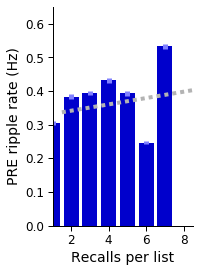

Number of patients in PRE v. recalls: 88
Number of low recall patients: 42
Number of high recall patients: 42
T-test between delta ripple rates: p = 0.2905427151555772
T-test between t-stats for each group instead: p = 0.4914617685778625
t-statistic: 0.6910885071076018
T-test between PRE bin ripple rate: p = 0.10953403234739158


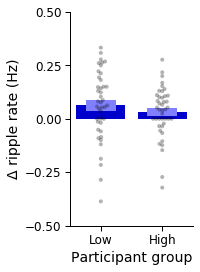

Number of participants in plot: 84
Min: -2.7001390428060255, Max: 4.8145572640809196


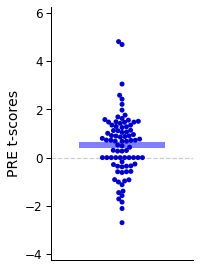

One-sample t-test of t-scores: 0.00034107422595970095
t-statistic: 3.736882724457924


/home1/john/johnModules/general.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  second_test = num == 'nan' # some string types don't work with above line


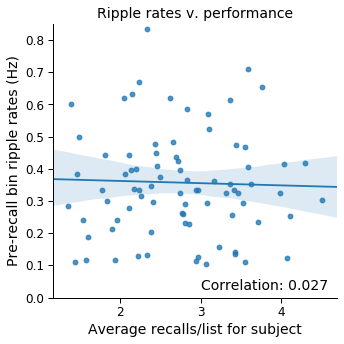

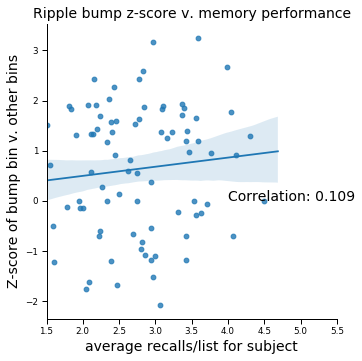

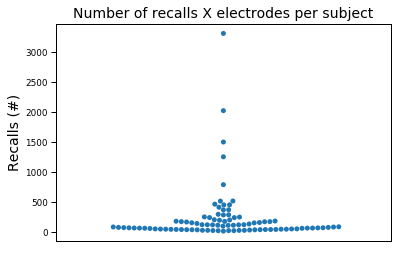

P-values for ME model with indicator between key bin v. 1 second earlier bin (1s and 0s, respectively)
               Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    ripple_rates
No. Observations:    19617      Method:                REML        
No. Groups:          88         Scale:                 1.5356      
Min. group size:     10         Likelihood:            -32074.5852 
Max. group size:     3303       Converged:             Yes         
Mean group size:     222.9                                         
-------------------------------------------------------------------
                          Coef.  Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                  0.025    0.027 0.928 0.353 -0.027  0.077
num_recalls                0.012    0.008 1.579 0.114 -0.003  0.027
subject Var                0.000    0.007                          
subject x num_recalls Cov -0

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [9]:
save_figs = 0

import seaborn as sb
from scipy.stats import ttest_ind
    
def defaultPlotting(): 
    sb.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")

if min_trials > 0 and corrected_for_nans == 0:
    
    good_subs = np.array(trial_accum)>=min_trials
    rate_accum = np.array(rate_accum)[good_subs]  
    rate_accum2 = np.array(rate_accum2)[good_subs] # bin 1 sec earlier
    sub_z_score = np.array(sub_z_score)[good_subs]
    sub_Ts1 = np.array(sub_Ts1)[good_subs]    
    trial_accum = np.array(trial_accum)[good_subs]    
    temp_sub_names = np.array(temp_sub_names)[good_subs]    
    
#     np.mean(sub_Ts2)
#     np.std(sub_Ts2)/np.sqrt(50)
#     sub_Ts2 = np.array(sub_Ts2)[good_subs]

    sub_avg_recall_num = np.array(sub_avg_recall_num)[good_subs]
    
    corrected_for_nans = 1


### $$$# subject-level figures we decided on ##$$###$

if 'dg' in location_selected:
    min_rate = 0.0
    plot_color = [(0.8,0,0)]
    lmplot_color = (0.8,0,0,0)
    errorbar_color = (1,0.5,0.5)
    line_color = 'darkred'
elif region_name == 'ENT':
    min_rate = 0.0 # for ENT and PHC I don't do further stats so just set to 0 to show all the datapoints in the swarm
    plot_color = [(0.5,0.5,0)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0.8,0.8,0)
    line_color = 'black'
elif region_name == 'PHC':
    min_rate = 0.0
    plot_color = [(0,0.5,0.5)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0,0.8,0.8)
    line_color = 'black' 
elif location_selected == 'ca1' or location_selected == '':
    min_rate = 0.0 # for CA1 and DG I require a FR minimum for the two bins being compared since I do further stats on them
    plot_color = [(0,0,0.8)]
    lmplot_color = (0,0,0.8,0)
    errorbar_color = (0.5,0.5,1)
    line_color = 'darkblue'
if type(location_selected)==list:
    if 'ca3' in location_selected:
        location_selected = 'ca3dg'
    elif 'ca1' in location_selected:
        location_selected = 'ca1dg'    
    
    
## Ripple rate in key bin v. avg_recall_num

good_subs = (rate_accum > min_rate) & (rate_accum2 > min_rate)
temp_sub_avg_recall_num = sub_avg_recall_num[good_subs]
rate_accum_delta = rate_accum[good_subs] - rate_accum2[good_subs]
good_sub_Ts1 = sub_Ts1[good_subs]

set_pubfig()
plot_df4 = pd.DataFrame({'avg_recall_num':temp_sub_avg_recall_num,'delta_ripple_rate':rate_accum_delta,
                        'sub_Ts1':good_sub_Ts1,'ripple_rate':rate_accum[good_subs]})
# sb.lmplot(x='avg_recall_num',y='ripple_rate',data=plot_df4,
#          scatter_kws = {'color': lmplot_color},line_kws = {'color': line_color},
#          size=4,aspect=1)

mean_rates_by_recall_num = []
ste_rates_by_recall_num = []
num_bins = np.unique(ME_df.avg_recall_num)
for recall_num in num_bins:
    mean_rates_by_recall_num.append(np.mean(ME_df.ripple_rate[ME_df.avg_recall_num==recall_num]))
    ste_rates_by_recall_num.append(np.std(ME_df.ripple_rate[ME_df.avg_recall_num==recall_num])
                                   /np.sqrt(len(ME_df.avg_recall_num==recall_num)))
    
figSub,axSub = plt.subplots(1,1, figsize=(3,4))
bar(num_bins,mean_rates_by_recall_num,yerr=ste_rates_by_recall_num,color=plot_color,
    error_kw=dict(lw=5, capsize=0, capthick=0, ecolor=errorbar_color))
xrange = np.arange(1.5,8.6,0.5)
plot(xrange,bin_model1.params[0]+bin_model1.params[1]*xrange,
     linestyle=(0, (1, 1)),color=(0.7,0.7,0.7),linewidth=4)
xticks(np.arange(2,9,2),np.arange(2,9,2))
axSub.set(ylim=(0,0.65),xlim=(1,8.5))

# changes from Mike
axSub.spines['right'].set_visible(False)
axSub.spines['top'].set_visible(False)
axSub.tick_params(labelsize=12)

ylabel('PRE ripple rate (Hz)')
xlabel('Recalls per list')
figSub.tight_layout()


if save_figs == 1:
    fname = '/home1/efegghi/SWR/figures/subject-level_plots/RRvMemory_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+str(recall_type_switch)+'_'+filter_type+'_'+sub_selection+'.pdf'
    savefig(fname,format='pdf',transparent=True)
save_fig = 0
show()
print('Number of patients in PRE v. recalls: '+str(len(np.unique(ME_df.subject))))
      

## high v. low recall patients

split_into = 2 # high v. low
delta_ripple_or_Ts = 0 # 0 for delta_ripples; 1 for sub_Ts

set_pubfig()

plot_df = copy(plot_df4) # plot_df4 is delta(rate) # plot_df5 is PRE bin

quartile_labels = range(split_into)
quartiles = pd.qcut(plot_df.avg_recall_num,split_into,labels=quartile_labels)
quartile_idxs = np.array(quartiles.values)
mean_ripples = []; ste_ripples = []
mean_mem = []; ste_mem = []
for val in np.unique(quartile_idxs):
    selected_quartile = quartile_idxs==val
    if delta_ripple_or_Ts == 0:
        mean_ripples.append(np.mean(plot_df.delta_ripple_rate[selected_quartile]))
        ste_ripples.append(np.std(plot_df.delta_ripple_rate[selected_quartile])/np.sqrt(len(plot_df.delta_ripple_rate[selected_quartile])))
    else:
        mean_ripples.append(np.mean(plot_df.sub_Ts1[selected_quartile]))
        ste_ripples.append(np.std(plot_df.sub_Ts1[selected_quartile])/np.sqrt(len(plot_df.sub_Ts1[selected_quartile])))        
plot_df['idxs'] = quartile_idxs # for swarmplot

figSub,axSub = plt.subplots(1,1, figsize=(3,4))
# axSub.bar(range(split_into),mean_ripples,yerr=ste_ripples,color=plot_color)
bar(range(split_into),mean_ripples,yerr=ste_ripples,color=plot_color,error_kw=dict(lw=30, capsize=0, capthick=0, ecolor=errorbar_color))

# changes from Mike
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)

add_swarm = 1
if add_swarm == 1:
    extra = '_swarm'
    if delta_ripple_or_Ts == 0:
        sb.swarmplot(x='idxs',y='delta_ripple_rate',data=plot_df, ax=axSub, color=(0,0,0), alpha=0.3, size=4)
        axSub.set(ylim=(-0.5,0.5))
        ytick_range = np.arange(-0.5,0.501,0.25)
        ylabel(u'Δ ripple rate (Hz)')
    else:
        sb.swarmplot(x='idxs',y='sub_Ts1',data=plot_df, ax=axSub, color=(0,0,0), alpha=0.3, size=4)
        axSub.set(ylim=(-4.25,6.25))
        ytick_range = np.arange(-4.01,6.01,2)        
        ylabel(u'PRE t-scores')
else:
    ylim(0,0.175)
    ytick_range = np.arange(0,0.151,0.05)
    extra = ''
    
yticks(ytick_range,fontsize=12)
xticks([0,1],['Low','High'],fontsize=12) # somehow these are reversed but the high patients have high ripples (see the means below)]
xlabel('Participant group')



print('Number of low recall patients: '+str(sum(np.array(quartiles.values))))
print('Number of high recall patients: '+str(sum(np.array(quartiles.values)==0)))

print('T-test between delta ripple rates: p = '+
    str(ttest_ind(plot_df.delta_ripple_rate[np.array(quartiles.values)==1], plot_df.delta_ripple_rate[np.array(quartiles.values)==0])[1]))

print('T-test between t-stats for each group instead: p = '+
    str(ttest_ind(plot_df.sub_Ts1[np.array(quartiles.values)==1], plot_df.sub_Ts1[np.array(quartiles.values)==0])[1]))
print('t-statistic: '+str(ttest_ind(plot_df.sub_Ts1[np.array(quartiles.values)==1], plot_df.sub_Ts1[np.array(quartiles.values)==0])[0]))

print('T-test between PRE bin ripple rate: p = '+
    str(ttest_ind(plot_df.ripple_rate[np.array(quartiles.values)==1], plot_df.ripple_rate[np.array(quartiles.values)==0])[1]))

# np.mean(plot_df.delta_ripple_rate[np.array(quartiles.values)==1]) # high ripple rate patients
# np.mean(plot_df.delta_ripple_rate[np.array(quartiles.values)==0])
# np.mean(plot_df.avg_recall_num[np.array(quartiles.values)==1]) # high memory patients
# np.mean(plot_df.avg_recall_num[np.array(quartiles.values)==0])

tight_layout()
if save_figs == 1:
    fname = '/home1/efegghi/SWR/figures/subject-level_plots/low_v_high_memory_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+str(recall_type_switch)+'_'+filter_type+'_'+sub_selection+extra+'.pdf'
    savefig(fname,format='pdf',transparent=True)
save_fig = 0
show()


# t-score histogram (PRE)

# (doing this at end since I ensure PRE bin and bin 1 sec earlier have > 0.1 hz RRs) 

set_pubfig()
temp_df = pd.DataFrame({'sub_Ts':good_sub_Ts1})
if region_name == 'HPC':
    fig, ax = subplots(figsize=(3,4))
else:
    fig, ax = subplots(figsize=(3,3))

# first plot the error bars
st_err = np.std(good_sub_Ts1)/np.sqrt(len(good_sub_Ts1))
bar_bottom = np.mean(good_sub_Ts1)-st_err
bar_height = 2*st_err
bar(x=0,height=bar_height,width=0.6,bottom=bar_bottom,color=errorbar_color)

# changes from Mike
yticks(fontsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# now the swarm
p1 = sb.swarmplot(ax=ax,y='sub_Ts', data=temp_df, palette=plot_color) 
# ax1 = p1.axes
ax.axhline(0, ls='--',color=(0.8,0.8,0.8))
ax.set(xticks=[])
ax.tick_params(labelsize=12)
if region_name == 'HPC':
    if selected_period == 'surrounding_recall':
        ax.set(ylim=(-4.25,6.25))
    else:
        ax.set(ylim=(-4,4))
else:
    ax.set(ylim=(-2.6,4.25)) # for MTL
ylabel('PRE t-scores')
tight_layout()
print('Number of participants in plot: '+str(len(good_sub_Ts1)))
print('Min: '+str(np.min(good_sub_Ts1))+', Max: '+str(np.max(good_sub_Ts1)))

if save_figs == 1:
    fname = '/home1/efegghi/SWR/figures/subject-level_plots/t-score_histo_'+exp+'_'+region_name+'_'+\
        location_selected+'_'+str(recall_type_switch)+'_'+filter_type+'_'+sub_selection+'.pdf'
    savefig(fname,format='pdf',transparent=True)
save_fig = 0
show()
# print sign test across subjects too
test_sub_Ts1 = good_sub_Ts1[~isNaN(good_sub_Ts1)]
t_stat,onesample_p = stats.ttest_1samp(test_sub_Ts1,0)
print('One-sample t-test of t-scores: '+str(onesample_p))
print('t-statistic: '+str(t_stat))


##$$$ ###



# ## For math period let's also do post-recall 
# # (doing this in post-recall bin)

# good_sub_Ts2 = sub_Ts2[good_subs] # should really use good_subs based on sub_Ts2 but just using based on pre-recall bins for now

# set_pubfig()
# temp_df = pd.DataFrame({'sub_Ts':good_sub_Ts2})
# if region_name == 'HPC':
#     fig, ax = subplots(figsize=(3,4))
# else:
#     fig, ax = subplots(figsize=(3,3))

# # first plot the error bars
# st_err = np.std(good_sub_Ts2)/np.sqrt(len(good_sub_Ts2))
# bar_bottom = np.mean(good_sub_Ts2)-st_err
# bar_height = 2*st_err
# bar(x=0,height=bar_height,width=0.6,bottom=bar_bottom,color=errorbar_color)

# # changes from Mike
# yticks(fontsize=12)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# # now the swarm
# p1 = sb.swarmplot(ax=ax,y='sub_Ts', data=temp_df, palette=plot_color) 
# # ax1 = p1.axes
# ax.axhline(0, ls='--',color=(0.8,0.8,0.8))
# ax.set(xticks=[])
# ax.tick_params(labelsize=12)
# if region_name == 'HPC':
#     if selected_period == 'surrounding_recall':
#         ax.set(ylim=(-2.25,6.25))
#     else:
#         ax.set(ylim=(-4,4))
# else:
#     ax.set(ylim=(-2.6,4.25))
# ylabel('POST t-scores')

# tight_layout()

# if save_figs == 1:
#     fname = '/home1/efegghi/SWR/figures/subject-level_plots/t-score_histo_POST_'+exp+'_'+region_name+'_'+\
#         location_selected+'_'+str(recall_type_switch)+'_'+filter_type+'_'+sub_selection+'.pdf'
#     savefig(fname,format='pdf',transparent=True)
# save_fig = 0
# show()
# # print sign test across subjects too
# test_sub_Ts2 = good_sub_Ts2[~isNaN(good_sub_Ts2)]
# _,onesample_p = stats.ttest_1samp(test_sub_Ts2,0)
# print('One-sample t-test of t-scores: '+str(onesample_p))


## Pre-recall ripple rates v. temporal clutsering

set_pubfig()
plot_df5 = pd.DataFrame({'avg_recall_num':sub_avg_recall_num,'ripple_rates':rate_accum})
# take only rates > usually defined 0.1 Hz minimum
plot_df5 = plot_df5[plot_df5.ripple_rates>0.1]

fig1 = sb.lmplot(x='avg_recall_num',y='ripple_rates',data=plot_df5) #,
#                  line_kws = {'color': 'black'},scatter_kws = {'color': 'black'})
gca().set(ylim=(0,0.85))
gca().tick_params(labelsize=12)
# gca().set_xticks(gca().get_xticks())
# gca().set_xticklabels(gca().get_xticks(),rotation=0)
# gca().set_ylabel(size=14)
# gca().set(xticks=np.arange(2,5,0.5))

plot_corr = np.corrcoef(sub_avg_recall_num,rate_accum)[0][1]
annotate('Correlation: '+str(np.round(plot_corr,3)),(3,0.025))
ylabel('Pre-recall bin ripple rates (Hz)')
xlabel('Average recalls/list for subject')
title('Ripple rates v. performance')
gcf().tight_layout()
show()


# Z-scores v. temporal clustering
plot_df6 = pd.DataFrame({'avg_recall_num':sub_avg_recall_num,'sub_z_score':sub_z_score})
sb.lmplot(x='avg_recall_num',y='sub_z_score',data=plot_df6)
plot_corr = np.corrcoef(sub_avg_recall_num,sub_z_score)[0][1]
annotate('Correlation: '+str(np.round(plot_corr,3)),(4,0))
ylabel('Z-score of bump bin v. other bins')
xlabel('average recalls/list for subject')
title('Ripple bump z-score v. memory performance')
gca().set(xlim=(1.5,5.5))
show()    

# trial histogram
set_pubfig()
sb.swarmplot(y=trial_accum) 
gca().set(xticks=[])
ylabel('Recalls (#)')
title('Number of recalls X electrodes per subject')
show()


## let's do a mixed model on this data too since correlation isn't ideal due to varying sample sizes across patients ##

rr_df = pd.DataFrame(data={'session':ME_sessions,'subject':ME_subjects,
                           'ripple_rates':np.array(ME_bin2)-np.array(ME_bin0),'num_recalls':ME_recall_num
                          })
vc = {'session':'0+session'} # to nest sessions in subjects
# intercept included when using smf
rr_model = smf.mixedlm("ripple_rates ~ num_recalls", rr_df, groups="subject",
                       vc_formula=vc, re_formula="1+num_recalls") 
rr_fit = rr_model.fit(reml=True, method='nm',maxiter=2000)

print('P-values for ME model with indicator between key bin v. 1 second earlier bin (1s and 0s, respectively)')
print(rr_fit.summary()) #pvalues)
print('Key num_recalls X bin interaction: '+str(np.round(rr_fit.pvalues[1],4)))

a=1;

# Big raster

(4691, 2000)


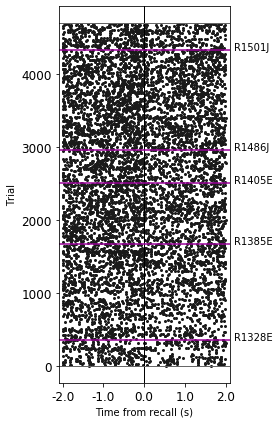

In [66]:

## for the raster and PSTH binarize the data by using the start indices of the ripple

sr_factor = 2 # always 2 since downsampled everything to 500 Hz

save_raster = 0

elec_dividers_on = 0 # toggles gray lines between electrodes
session_dividers_on = 0 # toggles cyan lines between sessions

width = 4 #y=100 for data cleaning # (4,6) for Fig. 4b # (4,10) for Fig. 2a
height = 6

dot_color = (0.1,0.1,0.1)
between_subject_color = (0.6,0,0.6) # purple
between_session_color = (0,0.6,0.6) # cyan

%autoreload
if selected_period == 'surrounding_recall':
    psth_start = -2000
    psth_end = 2000
elif selected_period == 'encoding':
    psth_start = -700
    psth_end = 2300

# plot raster
subplots(1,1,figsize=(width,height))   
scatter(np.where(start_array)[1]*sr_factor+psth_start,np.where(start_array)[0],s=4,color=dot_color) # SWR time v. trial
xticks(np.round(np.arange(psth_start,psth_end+1,500),2),np.round(np.arange(psth_start/1000,psth_end/1000+1,0.5),2))
xlabel('Time from recall (s)')
ylabel('Trial')
ax = plt.gca()

ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]], linewidth=1,linestyle='-',color=(0,0,0))

last_sub = sub_names[0]
last_sess = sub_sess_names[0]
channels_per_session = []
trial_accum = 0
for s in range(1,len(trial_nums)):
    if (sub_names[s] != last_sub) | (s==1):
        if s != 1:
            # plot dark gray line between subjects
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=1.5,linestyle='-',color=between_subject_color)
            last_sub = sub_names[s]
            text(psth_end+200,0.5+np.sum(trial_nums[:s]),sub_names[s])
        else: 
            if session_dividers_on==1:
                # if 1st sub though gotta print that first gray line 
                plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=between_session_color)
                text(psth_end+200,0,sub_names[s]) # and print 1st sub name at y=0
    else: # plot lines between electrodes
        if elec_dividers_on == 1:
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=(.7,.7,.7))
    # plot lines between sessions
    if session_dividers_on==1:
        if sub_sess_names[s] != last_sess:
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.75,linestyle='-',color=between_session_color)
            last_sess = sub_sess_names[s]
            
    channels_per_session.append(np.unique(channel_nums_array[int(trial_accum):int(trial_accum+trial_nums[s])]))
    trial_accum = trial_accum+trial_nums[s]
    
plot([ax.get_xlim()[0],ax.get_xlim()[1]],-.5*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))        
plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums))*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))
ax.autoscale(enable=True, axis='y', tight=True)
yticks(fontsize=12)
xticks(np.arange(-2000,2001,1000),np.arange(-2,2.01,1),fontsize=12) #,rotation=90)
plt.tight_layout()
# print('Total FR events: '+str(total_recalls)) # these were in whole retrieval period so not kept in usual ripple alignment
# print('Kept FR events: '+str(kept_recalls))
print(start_array.shape);
if save_raster == 1:
    if elec_dividers_on == 1:
        plt.savefig('../figures/rasters/'+exp+'_'+'raster_'+region_name+'_'+location_selected+
                    '-'+str(recall_type_switch)+'-'+filter_type+'.pdf',transparent=True)       
    else:
        plt.savefig('../figures/rasters/'+exp+'_'+'raster_'+region_name+'_'+location_selected+
                    '-'+str(recall_type_switch)+'no_elecs-'+filter_type+'.pdf',transparent=True)
a=1;

# run these two cells to save PVTHs

In [10]:
%autoreload
import warnings

# make a PSTH based on start times of SWRs
bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?
psth_start = -2000
psth_end = 2000

PSTH,bin_centers = fullPSTH(start_array,bin_size,smoothing_triangle,sr,psth_start)
# bootstraps error bars by sampling from trials in raster with replacement samples number of
# times and then taking the standard deviation across those samples
# boot_samples = bootstrap(start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
#                bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,psth_start))
# boot_SD = np.std(boot_samples,0)

# get binned start array (trials X bins)
binned_start_array = binBinaryArray(start_array,bin_size,sr_factor)
if pad > 0:
    binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
print('done making binned start_array with shape:')
binned_start_array.shape

# # get trial X 1 categorical names for subjects and sessions # do this in start_array cell now
# if select_ordinal_position == 0: # if 0 already did this in last cell
#     subject_name_array,session_name_array = getSubSessPredictors(sub_names,sub_sess_names,trial_nums)

# note that output is the net ± distance from mean
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")  
    SE_plot = getMixedEffectSEs(binned_start_array,subject_name_array,session_name_array)
print('SEs created!')

# should all be same length! (sanity check)
print('Are these three the same length?? They should be!')
binned_start_array.shape
len(subject_name_array)
len(session_name_array)

done making binned start_array with shape:


(19621, 36)

SEs created!
Are these three the same length?? They should be!


(19621, 36)

19621

19621

done binning start_arrays


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


/home1/john/SWR/figures/IRIonly/SWR_catFR1_HPC_ca1_0_soz_in_hamming_whole-LT_5000.p
Test 1 p-value: 4.916422340288111e-16
Test 2 p-value: 0.04334026467368064
19621 recalls


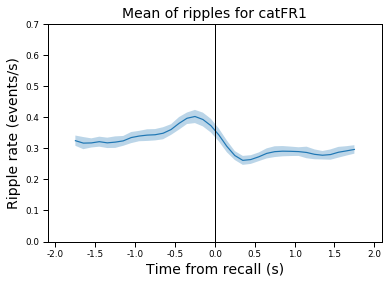

In [11]:
save_plot_data = 0

plot_sig_bars = 0

# let's measure significance at two key 500 ms bins (and compare to similar bin 500 ms earlier/later)
stats_bin = 500 # time bin width in ms to test stats on

first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
first_end = -100
second_start = 200 # same idea
second_end = 1700

start_array.shape
binned_first_stats_array = start_array[:,int((first_start-psth_start)/sr_factor):int((first_end-psth_start)/sr_factor)]
binned_second_stats_array = start_array[:,int((second_start-psth_start)/sr_factor):int((second_end-psth_start)/sr_factor)]
binned_first_stats_array = binBinaryArray(binned_first_stats_array,stats_bin,sr_factor)
binned_second_stats_array = binBinaryArray(binned_second_stats_array,stats_bin,sr_factor)
print('done binning start_arrays'); binned_start_array.shape

bin_model1 = MEstatsAcrossBins(binned_first_stats_array[:,[0,2]],subject_name_array,session_name_array)
bin_model2 = MEstatsAcrossBins(binned_second_stats_array[:,[0,2]],subject_name_array,session_name_array)
# bin_model1.summary()
# bin_model2.summary()


## plot PSTH and save data for plot (see SWRplots)


subplots(1,1,figsize=(6,4))
xr = bin_centers #np.arange(psth_start,psth_end,binsize)

# plot smoothed mean +/- SE
if pad > 0:
    plot(xr[pad:-pad],PSTH[pad:-pad])
    fill_between(xr[pad:-pad], PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3)
else:
    plot(xr,PSTH)
    fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:], alpha = 0.3)

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
if selected_period == 'surrounding_recall':
    xlabel('Time from recall (s)')
elif selected_period == 'math_retrieval':    
    xlabel('Time from response (s)')
elif selected_period == 'math':
    xlabel('Time from problem onset (s)')
ylabel('Ripple rate (events/s)')
title('Mean of ripples for '+exp)
# tight_layout()
ax = plt.gca()
if filter_type == 'hamming':
    ylim = 0.7 # keep it here since occasionally CIs get kinda high
else:
    ylim = 0.45
ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0));
x_width = [ax.get_xlim()[0],ax.get_xlim()[1]]

# plot bands of significance
if plot_sig_bars == 1:
    if bin_model1.pvalues[1] < 0.05:
        plot([first_end-stats_bin,first_end],[0.2,0.2],color=(1,0.5,0))
    if bin_model2.pvalues[1] < 0.05:
        plot([second_start,second_start+stats_bin],[0.2,0.2],color=(1,0.5,0))
num_trials = start_array.shape[0]


# get directories for if you save (don't put this in save_plot_data below since want p-values printed at bottom close to figures)
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
path_name = '/home1/efegghi/SWR/figures/'+subfolder
if type(location_selected)==list:
    if 'ca3' in location_selected:
        location_selected = 'ca3dg'
    elif 'ca1' in location_selected:
        location_selected = 'ca1dg'

fn = os.path.join(path_name,
    'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                  '_'+filter_type+'_'+sub_selection+'-LT_5000.p') # -GT_5000.p' # -LT_5000.p' #'-intrusions.p' #'-ANLIPLOT.p'
print(fn)
print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
print('Test 2 p-value: '+str(bin_model2.pvalues[1]))
print(str(num_trials)+' recalls')

if save_plot_data == 1:
    # get strings for path name for save and loading cluster data

    if os.path.isdir(path_name) == False:
        os.mkdir(path_name)

    with open(fn,'wb') as f:
        pickle.dump({'bin_centers':bin_centers,'PSTH':PSTH,'SE_plot':SE_plot,'num_trials':num_trials,
                    'bin_model1':bin_model1,'bin_model2':bin_model2,
                    'binned_first_stats_array':binned_first_stats_array,'binned_second_stats_array':binned_second_stats_array,
                    'subject_name_array':subject_name_array,'session_name_array':session_name_array,
                    'electrode_array':electrode_array,'channel_coords_array':channel_coords_array}, f)
a=1;

## What about SWR ripple_durations?! Expect longer = better memory
## (load surrounding_recall and get start_array/subject_name_array first)

Total ripples: 20098


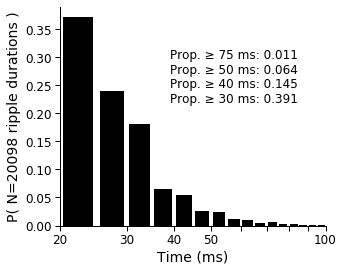

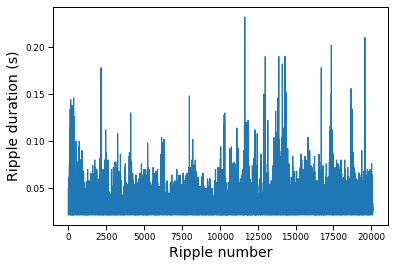

In [13]:
# get ripple_durations and plot distribution

save_plot = 0

set_pubfig()
ripple_durations = []
ripple_midpoints = []
subject_name_array_by_ripple = []
session_name_array_by_ripple = []
for trial in range(start_array.shape[0]):
    starts = np.array(np.where(start_array[trial]))
    ends = np.array(np.where(end_array[trial]))
    ripple_durations = np.append(ripple_durations,ends-starts)
    ripple_midpoints = np.append(ripple_midpoints,starts+(ends-starts)/2)
    # tile by number of ripples
    ripples_this_trial = len(starts[0])
    subject_name_array_by_ripple.extend(np.tile(subject_name_array[trial],ripples_this_trial))
    session_name_array_by_ripple.extend(np.tile(session_name_array[trial],ripples_this_trial))
subject_name_array_by_ripple = np.array(subject_name_array_by_ripple)
session_name_array_by_ripple = np.array(session_name_array_by_ripple)
    
ripple_durations = ripple_durations*sr_factor/1000 # convert to s
ripple_durations = ripple_durations[ripple_durations>0.02]
print('Total ripples: '+str(len(ripple_durations)))

start_value = 0.0199 # some kind of precision error otherwise that I can't figure out...but this makes sure it's using 20-24.99 ms
end_value = 0.0999
bin_size = 0.1/20
# this replicates the error:
# bad_bins = np.arange(0.02,0.1+0.001,0.005)
# np.histogram(ripple_durations,bins=bad_bins)
# sum((ripple_durations>=0.02) & (ripple_durations<0.025))
# sum((ripple_durations>=0.025) & (ripple_durations<0.03))
if filter_type == 'butter':
    ripple_durations[ripple_durations<0.025] = 0.025 # almost all are 24 ms which must have gotten shifted by rounding since min is 25 

# for linear plot
# plotHistoBar(ripple_durations,start_value,end_value,0.005,tick_range_divisor=5,normalize=True,log_scale=False)

# for log plot
subplots(1,1, figsize=(5,4))
bins = np.arange(start_value,end_value+bin_size+0.001,bin_size) # added bin+0.001 to show last bin and last tick
hist = np.histogram(ripple_durations,bins=bins)
yvalues = hist[0]/sum(hist[0]) # normalize
xr = bins[:-1] #(bins[1:]+bins[:-1])/2
ax = plt.bar(xr+bin_size/2,yvalues,width=0.8*bin_size,color='k')
xscale('log')
xlim(0.02,0.10)
# xscale('log', subsx=range(10)) # sets number of xticks. Dunno why we need 12 to get 10
xticks(ticks=np.arange(0.02,0.101,0.01),labels=['20','30','40','50','','','','','100'],size=12)
yticks(size=12)
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)

xlabel('Time (ms)')
ylabel('P( N='+str(len(ripple_durations))+' ripple durations )')
max_hist = np.max(yvalues)
text_x = 0.039
text(text_x,0.8*max_hist,'Prop. ≥ 75 ms: '+str(np.round(sum(ripple_durations>=0.075)/len(ripple_durations),3)),fontsize=12)
text(text_x,0.73*max_hist,'Prop. ≥ 50 ms: '+str(np.round(sum(ripple_durations>=0.05)/len(ripple_durations),3)),fontsize=12)
text(text_x,0.66*max_hist,'Prop. ≥ 40 ms: '+str(np.round(sum(ripple_durations>=0.04)/len(ripple_durations),3)),fontsize=12)
text(text_x,0.59*max_hist,'Prop. ≥ 30 ms: '+str(np.round(sum(ripple_durations>=0.03)/len(ripple_durations),3)),fontsize=12)
# text(0.018,-0.031,'2x$10^{-1}$',fontsize=9)

tight_layout()

if save_plot == 1:
    plt.savefig('../figures/durations/'+exp+'_'+'Durations_'+region_name+'-'+location_selected+'_'+str(recall_type_switch)+\
                '_'+filter_type+'.pdf',transparent=True) 

show()
plot(ripple_durations)
xlabel('Ripple number')
ylabel('Ripple duration (s)');


In [15]:
# what about ripple_durations of ripples in the PSTH? Are they longer just before recall?
# could be clever and use time of peak power but makes just as much sense to use midpoint
import statsmodels.formula.api as smf

bin_size = 0.1
smoothing_triangle = 5

# get midpoint list from for loop above
corrected_ripple_midpoints = (ripple_midpoints*sr_factor+-2000)/1000 # convert to s and adjust to offset
bins = np.arange(-2,2+bin_size+bin_size+0.001,bin_size)
xr = (bins[1:]+bins[:-1])/2

# Could also plot durations at each time bin (note >40 ms analysis removed as of 2020-07-17)
mean_durations_by_bin = []
se_durations_by_bin = []
number_ripples_in_bin = []
mean_values = []
bin_CIs = []
for bin in bins[:-3]:
    # get indices for times in each bin so can grab durations
    ripples_in_bin_mask = [(corrected_ripple_midpoints>=bin) & (corrected_ripple_midpoints<bin+bin_size)]
    durations_in_bin = ripple_durations[ripples_in_bin_mask]
    number_ripples_in_bin.append(len(durations_in_bin))
    mean_durations_by_bin.append(np.mean(durations_in_bin))
    se_durations_by_bin.append(np.std(durations_in_bin)/np.sqrt(len(durations_in_bin)))
    
    # let's properly get CIs for each bin
    bin_session = session_name_array_by_ripple[ripples_in_bin_mask] # already have ripples for this bin, get sub and sess identifiers
    bin_subject = subject_name_array_by_ripple[ripples_in_bin_mask]
    CI_df = pd.DataFrame(data={'session':bin_session,'subject':bin_subject,'durations':durations_in_bin})
    vc = {'session':'0+session'}
    get_bin_CI_model = smf.mixedlm("durations ~ 1", CI_df, groups="subject", vc_formula=vc)
    bin_model = get_bin_CI_model.fit(reml=False, method='nm')
    mean_values.append(bin_model.params.Intercept)
    bin_CIs = superVstack(bin_CIs,bin_model.conf_int().iloc[0].values)
# get CI distances at each bin by subtracting from means
CI_plot = np.array(bin_CIs.T)
CI_plot[0,:] = mean_values - CI_plot[0,:] # - difference to subtract from PSTH
CI_plot[1,:] = CI_plot[1,:] - mean_values # + difference to add to PSTH
    
# triangle smooth
smoothed_mean_duration = triangleSmooth(mean_durations_by_bin,smoothing_triangle)

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


IndexError: boolean index did not match indexed array along dimension 0; dimension is 20098 but corresponding boolean dimension is 24994

In [ ]:
# stats on key bins
stats_bin = 5 # width of test (in bins)
PSTH_start = -2000

# going to make sequence of 3 bins and test 1st v. 3rd 
first_start = 4  # -1600 so will be -1600:-1100 v. -600:-100 with stats_bin=5
second_start = 22 # same idea starting at 200


for test in range(2):
    durations = []
    session_name = []
    subject_name = []
    bin_label = []    
    if test == 0:
        bin_starts = [first_start,first_start+10] # first bin at -1600:-1100 and second a second later
    else:
        bin_starts = [second_start,second_start+10] # same idea
    
    # now, to set up ME pairwise stats, append each time_bin to bottom and duplicate
    for time_bin in bin_starts: 
        ripples_in_bin_mask = [(corrected_ripple_midpoints>=bins[time_bin]) & (corrected_ripple_midpoints<(bins[time_bin+stats_bin]))]
        print(np.mean(ripple_durations[ripples_in_bin_mask]))
        durations.extend(ripple_durations[ripples_in_bin_mask])
        session_name.extend(session_name_array_by_ripple[ripples_in_bin_mask])
        subject_name.extend(subject_name_array_by_ripple[ripples_in_bin_mask])
        bin_label.extend(np.tile(str(time_bin),sum(ripples_in_bin_mask)))
    
    bin_df = pd.DataFrame(data={'session':session_name,'subject':subject_name,
                               'bin':bin_label,'durations':durations})
    vc = {'session':'0+session'}
    sig_bin_model = smf.mixedlm("durations ~ bin", bin_df, groups="subject", vc_formula=vc)
    bin_model = sig_bin_model.fit(reml=False, method='nm')
    print(bin_model.params)
    print('Test '+str(test)+' p-value: '+str(bin_model.pvalues[1]))

# plot
fig1 = figure()
ax1 = fig1.add_subplot(111)
line1 = plot(xr[:-2],smoothed_mean_duration)
fill_between(xr[:-2], smoothed_mean_duration-CI_plot[0,:], smoothed_mean_duration+CI_plot[0,:], alpha = 0.3)
ax1.set_ylim(0.025,0.033)
ylabel('Ripple duration (s)')
xlabel('Time from free recall (s)')
title('Ripple duration before and after recall')
# second axis
ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
line2 = ax2.plot(xr[:-2],number_ripples_in_bin, 'r-')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ylabel('Ripples (#)')
ax1.legend(line1,{"Avg. duration (95% CI)"})
ax2.legend(line2,{"Number of ripples"},loc='lower left');

## let's look at some of these SWR traces! 

/home1/john/Downloads/cmlreaders-master/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1345D/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1345D/tal/R1345D_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:364: UserWarning: The filtered method is not very flexible. Consider using filters in ptsa.data.filters instead.
  warnings.warn("The filtered method is not very flexible. "


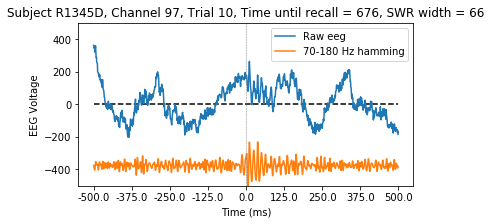

In [51]:
# Need to load start_array for given sub_df with your session first 
# MAKE SURE YOU SET TO 0 to get every trial or it won't align! Also make sure using all HPC and not a subfield via location_selected

# start_array is recall_events X time with binary 1 for start of each detected SWR

%autoreload
from ptsa.data.filters import ButterworthFilter
from scipy.signal import firwin,filtfilt

which_session = 0 # select from the df
which_channel = 97 # 83
first_trial = 10
trials_to_print = 1 # note: will skip trials with no ripples

# to get right events
recall_type_switch = 0
IRI = 2000
recall_minimum = 2000

desired_sample_rate = 500. # even if SR is >500 for eeg the desired rate for the ripple arrays was set to 500
desired_sr_factor = int(1000/desired_sample_rate) # sr_factor is defined below via eeg sr_factor
trans_width = 5.
psth_start = -2000
psth_end = 2000

# bb,aa = butter(2,[70/250,180/250],btype='band') # Butterworth test filter

temp_sub_df = sub_df[0:which_session+1] 
array_trial_offset = int(np.sum(trial_nums[:which_session]))
temp_sub_df

pre_rip = -500 # plots this many ms before and after the ripple
post_rip = 500

ymin = -500 #np.min(stim_eeg[trial,:])
ymax = 500 #np.max(stim_eeg[trial,:])
display_mult = 2 # increase 80-120 Hz by this factor to see it better on graph
y_offset = -ymax/2 # move 80-120 filtered band down for visualization purposes

yr = np.arange(ymin,ymax)
num_ripples = np.sum(start_array)

trial_ct = 0; print_ct = 0
for row in temp_sub_df.itertuples():
    # get bipolar pairs
    sub = row.subject; mont = int(row.montage); loc = int(row.localization)
    exp = row.experiment; session = int(row.session)
    reader = CMLReadDFRow(row)
    evs = reader.load('task_events')
    # get localizations (region info)
    pairs = reader.load('pairs')
    try:
        localizations = reader.load('localization')
    except:
        localizations = []
    
    ### get evs_free_recall like above
    evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.recalled==True)] # recalled word AND correct (from this list...no instrusions).        
    word_evs = evs[evs['type']=='WORD'] # get words 

    # select which recalls??         
    [recall_selection_name,selected_recalls_idxs] = selectRecallType(recall_type_switch,evs_free_recall,IRI,recall_minimum)     

    _,nonrepeat_indicator = removeRepeatedRecalls(evs_free_recall,word_evs) # remove free recalls that happened more than once

    # let's make sure remaining recalls are not repeated, have eeg, and are not from non-practice lists
    good_recalls = selected_recalls_idxs & (nonrepeat_indicator>0) & np.array(evs_free_recall.eegoffset>-1) & np.array(evs_free_recall.list > -1)
    evs_free_recall = evs_free_recall[good_recalls]
    ###
    
    tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
    elec_regions,atlas_type,pair_number,has_stein_das = get_elec_regions(localizations,pairs)      
    
    eeg = reader.load_eeg(events=evs_free_recall, rel_start=psth_start, rel_stop=psth_end, clean=True, scheme=pairs)
    eeg_sr = eeg.samplerate
    
    ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(eeg_sr/trans_width)
    FIR_filter = firwin(int(ntaps+1), [70.,180.], fs=eeg_sr, window='hamming',pass_zero='bandpass')
    
    sr_factor = 1000/eeg_sr
    xr = np.arange(0,(post_rip-pre_rip)/sr_factor)
    eeg_ptsa = eeg.to_ptsa()
    eeg_ptsa = eeg_ptsa.baseline_corrected((psth_start,psth_end))
    eeg_vaz = eeg_ptsa.filtered([80.,120.], filt_type='bandpass', order=2) # Butterworth 2nd order a la Vaz/Zaghloul
    eeg_norman = filtfilt(FIR_filter,1.,eeg_ptsa) 
#     eeg_butter_70180 = filtfilt(bb,aa,eeg_ptsa) # test Butterworth with 70-180 Hz...like combining two methods
#     eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
    
    for channel in range(len(elec_regions)):
        if channel == which_channel:
#         if elec_regions[channel] in HPC_labels:
            for trial in range(len(evs_free_recall)): # maximum trials is # elecs * recall_events
                if trial_ct >= (first_trial) and print_ct<trials_to_print:
                    if np.sum(start_array[trial_ct+array_trial_offset])>0: # if there is a ripple in this trial
                        rip_times = (np.array(np.where(start_array[trial_ct]))*desired_sr_factor)[0] # convert to ms since was set to 500 Hz
                        rip_durations = ((desired_sr_factor*np.array(np.where(end_array[trial_ct])))-rip_times)[0]
                        for rip in range(len(rip_times)): # get each ripple 
                            rip_time = rip_times[rip]
                            rip_length = rip_durations[rip]
                            #print(str(rip_time+psth_start))
                            # note: any time dealing with eeg, need to account for sampling rate (see all the sr_factors)
                            if rip_time>abs(pre_rip) and rip_time<(eeg_ptsa.shape[2]*sr_factor-abs(post_rip)): # if enough time before/after ripple to plot

                                stim_eeg = eeg_ptsa[trial_ct,channel,int((rip_time+pre_rip)/sr_factor):int((rip_time+post_rip)/sr_factor)]
#                                 filt_eeg_vaz = eeg_vaz[trial_ct,channel,int((rip_time+pre_rip)/sr_factor): # eeg_butter_70180
#                                                                 int((rip_time+post_rip)/sr_factor)]
                                filt_eeg_norman = eeg_norman[trial_ct,channel,int((rip_time+pre_rip)/sr_factor):
                                                             int((rip_time+post_rip)/sr_factor)]
                                plt.figure(figsize=(6, 3)) 
                                ax = plt.subplot(111)
                                plt.plot(xr,stim_eeg)
#                                 plt.plot(xr,display_mult*filt_eeg_vaz+y_offset)
#                                 import ipdb; ipdb.set_trace()
                                plt.plot(xr,display_mult*filt_eeg_norman+y_offset*3/2)
                                plt.ylabel('EEG Voltage'); plt.xlabel('Time (ms)')
                                plt.plot(abs(pre_rip/sr_factor)*np.ones(len(yr)),yr,marker='',linewidth=0.5,linestyle='--',color=[0.5,0.5,0.5])
                                plt.legend(['Raw eeg','70-180 Hz hamming']) # '80-120 Hz butterworth'
                                plt.title('Subject '+sub+', Channel '+str(channel)+', Trial '+str(trial_ct)+', Time until recall = '
                                          +str(rip_time+psth_start)+', SWR width = '+str(rip_length))
                                plt.xticks(np.arange(0,post_rip-pre_rip+1,post_rip/4),np.arange(pre_rip,post_rip+1,post_rip/4))
                                ax.set_ylim([ymin,ymax])
                                plt.hlines(0,xr[0],xr[-1], linestyle='--', color='k')
                                print_ct+=1
                trial_ct+=1 # keep track of which trial we're on out of total ELEC X RECALL trials
a=1;

(19, 107, 4000)

<Figure size 864x360 with 0 Axes>

Text(0, 0.5, 'EEG Voltage')

Text(0.5, 0, 'Time (ms)')

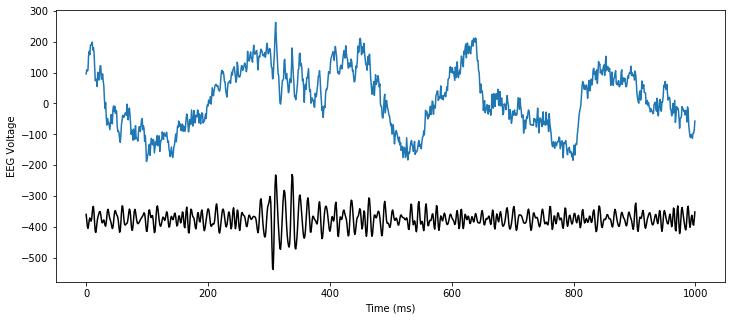

In [52]:
# plotting sandbox Fig. 4

# for Fig. 4g and 1b:
# R1345D, session 0, ch 97, trial 10, recall_type = 0, False for location_selected 
# R1345D, session 0, ch 98, trial 9, single with something looking like it beforehand

offset = 200 # offset from Time = 0
eeg_ptsa.shape

stim_eeg = eeg_ptsa[first_trial,which_channel,int((rip_time+pre_rip+offset)/sr_factor):int((rip_time+post_rip+offset)/sr_factor)]
filt_eeg_norman = eeg_norman[first_trial,which_channel,int((rip_time+pre_rip+offset)/sr_factor):
                             int((rip_time+post_rip+offset)/sr_factor)]
plt.figure(figsize=(12, 5)) 
ax = plt.subplot(111)
plt.plot(xr,stim_eeg)
plt.plot(xr,display_mult*filt_eeg_norman+y_offset*3/2,'k')
plt.ylabel('EEG Voltage'); plt.xlabel('Time (ms)')

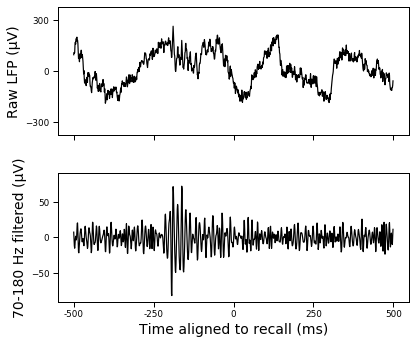

In [63]:
# plotting sandbox Fig. 1b

set_pubfig()

offset = 200 # offset from Time = 0
eeg_ptsa.shape

stim_eeg = eeg_ptsa[first_trial,which_channel,int((rip_time+pre_rip+offset)/sr_factor):int((rip_time+post_rip+offset)/sr_factor)]
filt_eeg_norman = eeg_norman[first_trial,which_channel,int((rip_time+pre_rip+offset)/sr_factor):
                             int((rip_time+post_rip+offset)/sr_factor)]
plt.figure(figsize=(6, 5)) 
ax = plt.subplot(211)
plt.plot(xr,stim_eeg,'k')
plt.ylabel('Raw LFP (μV)')
xticks(np.arange(0,post_rip-pre_rip+1,250),[])
yticks(np.arange(-300,301,300))
ax.set_ylim(-375,375)

ax = plt.subplot(212)
# plt.plot(xr,display_mult*filt_eeg_norman+y_offset*3/2,'k')
plt.plot(xr,filt_eeg_norman,'k')
plt.ylabel('70-180 Hz filtered (μV)'); plt.xlabel('Time aligned to recall (ms)')
xticks(np.arange(0,post_rip-pre_rip+1,250),np.arange(pre_rip,post_rip+1,250))
ax.set_ylim(-90,90)
tight_layout()

plt.savefig('../figures/spectrograms/Fig1b_example_filtering_R1345D.pdf',transparent=True);

## What about visualizing IED events?

array([0, 0, 4, ..., 2, 2, 0], dtype=uint64)

(2379, 2000)

500

(80, 2300)

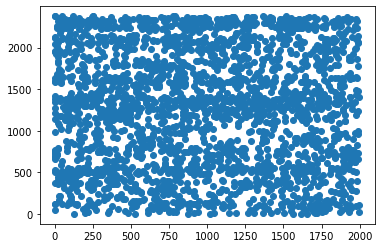

In [126]:
scatter(np.where(start_array)[1],np.where(start_array)[0])
np.sum(start_array,1)
start_array.shape
sr
iedlogic.shape

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1112M/tal/R1112M_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1112M/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1112M/eeg.noreref/R1112M_FR1_0_01Dec15_1545.params.txt
/data/eeg/R1112M/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePath

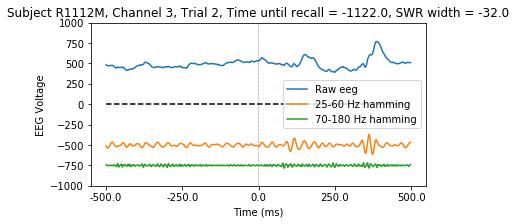

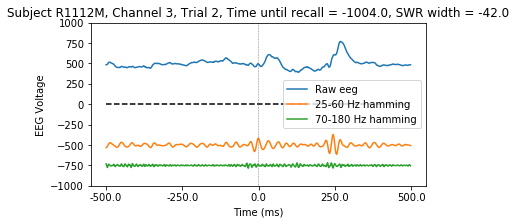

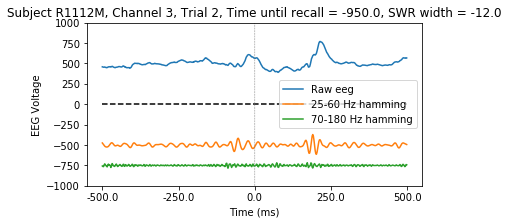

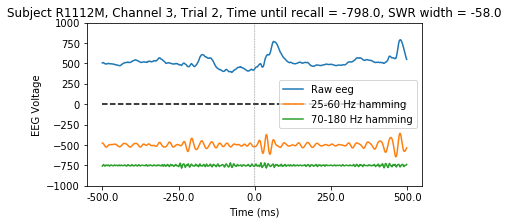

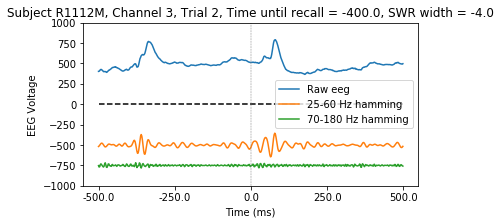

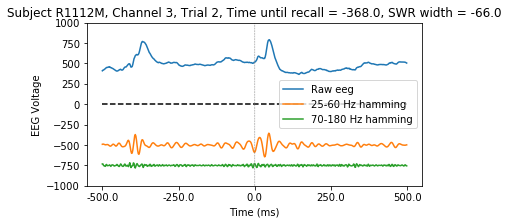

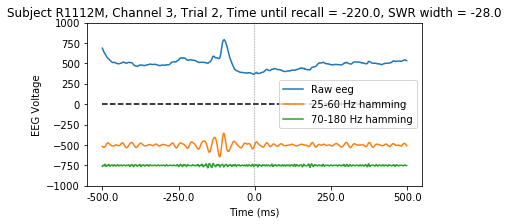

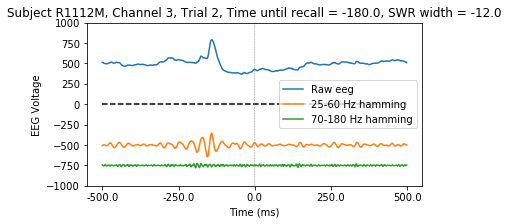

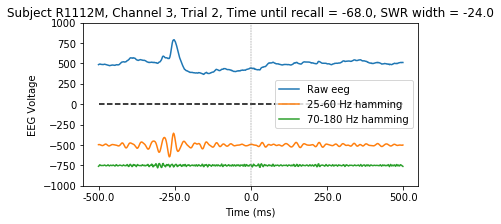

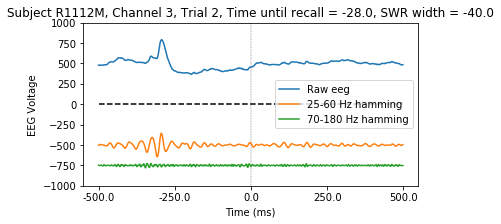

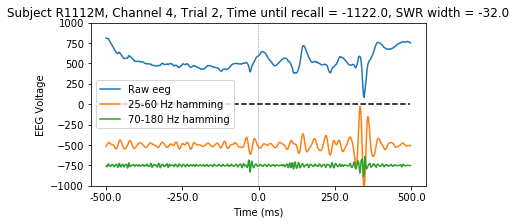

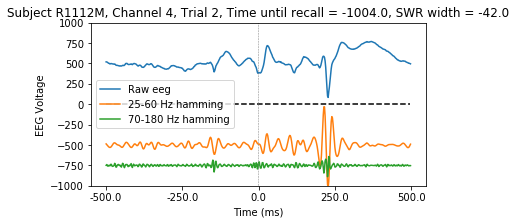

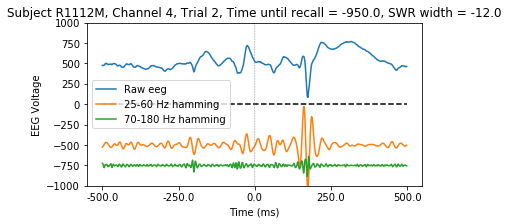

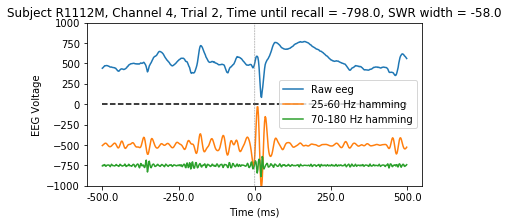

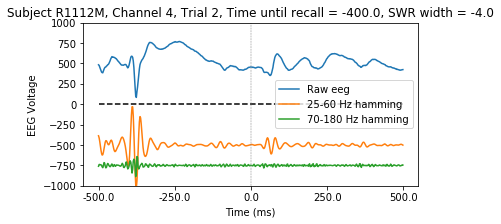

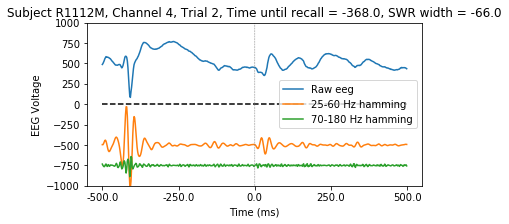

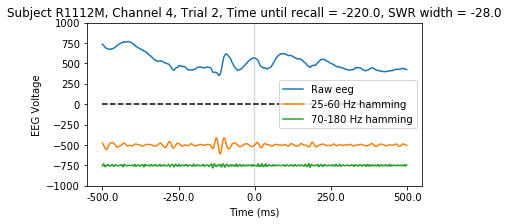

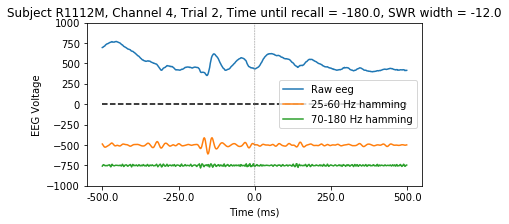

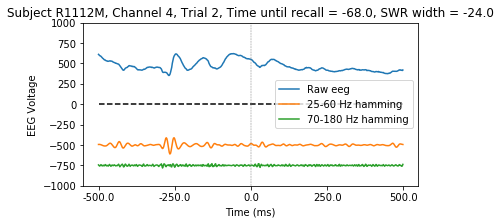

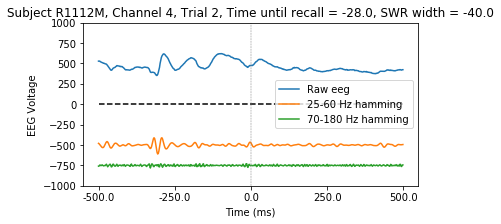

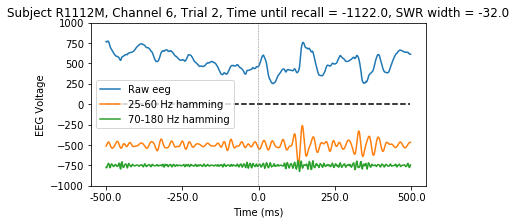

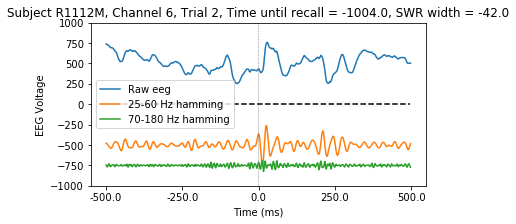

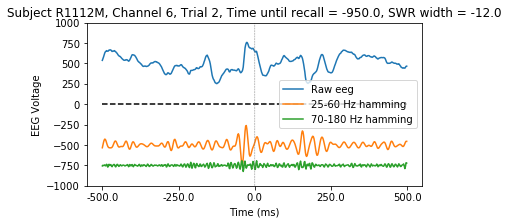

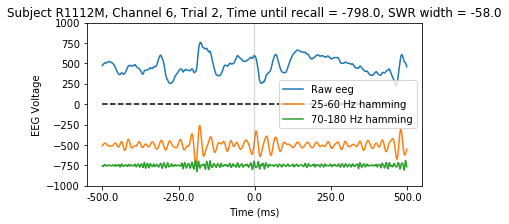

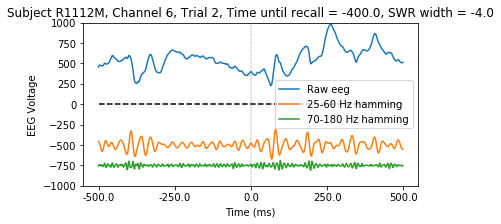

In [66]:
# create a start_array for IED array

desired_sample_rate = 500.
# iedlogic = downsampleBinary(iedlogic,sr/desired_sample_rate)
start_array,end_array = getStartEndArrays(iedlogic)

sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
desired_sr_factor = 1000/desired_sample_rate

%autoreload
from ptsa.data.filters import ButterworthFilter
from scipy.signal import firwin,filtfilt

which_session = 0 # select from the df
first_trial = 0
trials_to_print = 25 # note: will skip trials with no ripples

display_mult_ied = 3 # display IED multiplier
display_mult_rip = 5

pre_rip = -500 # plots this many ms before and after the ripple
post_rip = 500
trans_width = 5.
temp_sub_df = sub_df[0:which_session+1] 
array_trial_offset = int(np.sum(trial_nums[:which_session]))
temp_sub_df

ymin = -1000 #np.min(stim_eeg[trial,:])
ymax = 1000 #np.max(stim_eeg[trial,:])
y_offset = -ymax/2 # move 80-120 filtered band down for visualization purposes

yr = np.arange(ymin,ymax)
num_ripples = np.sum(start_array)

trial_ct = 0; print_ct = 0
for row in temp_sub_df.itertuples():
    # get bipolar pairs
    sub = row.subject; mont = int(row.montage); loc = int(row.localization)
    exp = row.experiment; session = int(row.session)
    reader = CMLReadDFRow(row)
    evs = reader.load('task_events')
    pairs = reader.load('pairs')
    evs_free_recall = evs[evs.type=='REC_WORD']
    # remove events with Inter-Recall Intervals too small. Use start time since that's what will show in PSTH
    evs_free_recall = evs_free_recall[np.append(True,np.diff(evs_free_recall.mstime)>IRI)] #abs(start))]
    tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
    elec_regions,_ = get_elec_regions(tal_struct)      
    
    eeg = reader.load_eeg(events=evs_free_recall, rel_start=psth_start, rel_stop=psth_end, clean=True, scheme=pairs)
    eeg_sr = eeg.samplerate
    
    ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(eeg_sr/trans_width)
    FIR_filter = firwin(int(ntaps+1), [70.,180.], fs=eeg_sr, window='hamming',pass_zero='bandpass')
    bandpass_25_60 = firwin(int(ntaps+1), [25.,60.], fs=eeg_sr, window='hamming',pass_zero='bandpass')
    
#     sr_factor = 1000/eeg_sr
    xr = np.arange(0,(post_rip-pre_rip)/desired_sr_factor)
    eeg_ptsa = eeg.to_ptsa()
    eeg_ptsa = eeg_ptsa.baseline_corrected((psth_start,psth_end))
#     eeg_vaz = eeg_ptsa.filtered([80.,120.], filt_type='bandpass', order=2) # Butterworth 2nd order a la Vaz/Zaghloul
    ied_norman = filtfilt(bandpass_25_60,1.,eeg_ptsa)
#     ied_vaz = ButterworthFilter(timeseries=eeg_ptsa, freq_range=200., filt_type='highpass',order=2).filter()
    eeg_norman = filtfilt(FIR_filter,1.,eeg_ptsa) 
#     eeg_butter_70180 = filtfilt(bb,aa,eeg_ptsa) # test Butterworth with 70-180 Hz...like combining two methods
#     eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
    
    for channel in range(len(elec_regions)):
        if elec_regions[channel] in HPC_labels:
            for trial in range(np.shape(start_array)[0]): # maximum trials is # elecs * recall_events
                rip_times = np.where(start_array[trial])[0]*desired_sr_factor # times in ms
                rip_ends = np.where(end_array[trial])[0]*desired_sr_factor
                if sum(rip_times)>0:
                    for i,rip_time in enumerate(rip_times):
                        if print_ct<trials_to_print:
    #                     if np.sum(start_array[trial_ct+array_trial_offset])>0: # if there is a ripple in this trial
                            rip_length = rip_time-rip_ends[i]
    #                         for rip in range(len(rip_times)): # get each ripple 
                            #print(str(rip_time+psth_start))
                            # note: any time dealing with eeg, need to account for sampling rate (see all the sr_factors)
                            if rip_time>abs(pre_rip) and rip_time<(eeg_ptsa.shape[2]*desired_sr_factor-abs(post_rip)): # if enough time before/after ripple to plot
                                stim_eeg = eeg_ptsa[trial,channel,int((rip_time+pre_rip)/desired_sr_factor):int((rip_time+post_rip)/sr_factor)]
                                filt_ied_norman = ied_norman[trial,channel,int((rip_time+pre_rip)/desired_sr_factor): # eeg_butter_70180
                                                                int((rip_time+post_rip)/desired_sr_factor)]
                                filt_eeg_norman = eeg_norman[trial,channel,int((rip_time+pre_rip)/desired_sr_factor):
                                                             int((rip_time+post_rip)/desired_sr_factor)]
                                plt.figure(figsize=(6, 3)) 
                                ax = plt.subplot(111)
                                plt.plot(xr,stim_eeg-y_offset)
                                plt.plot(xr,display_mult_ied*filt_ied_norman+y_offset)
                                plt.plot(xr,display_mult_rip*filt_eeg_norman+y_offset*3/2)
                                plt.ylabel('EEG Voltage'); plt.xlabel('Time (ms)')
                                plt.plot(abs(pre_rip/desired_sr_factor)*np.ones(len(yr)),yr,marker='',linewidth=0.5,linestyle='--',color=[0.5,0.5,0.5])
                                plt.legend(['Raw eeg','25-60 Hz hamming','70-180 Hz hamming']) 
#                                 plt.legend(['Raw eeg','>200 Hz highpass','70-180 Hz hamming']) 
                                plt.title('Subject '+sub+', Channel '+str(channel)+', Trial '+str(trial)+', Time until recall = '
                                          +str(rip_time+psth_start)+', SWR width = '+str(rip_length))
                                plt.xticks(np.arange(0,post_rip-pre_rip+1,post_rip/4),np.arange(pre_rip,post_rip+1,post_rip/2))
                                ax.set_ylim([ymin,ymax])
                                plt.hlines(0,xr[0],xr[-1], linestyle='--', color='k')
                                print_ct+=1
#                 trial_ct+=1 # keep track of which trial we're on out of total ELEC X RECALL trials
a=1;

In [89]:
## Norman method of getting Bootstrap error bars and cluster-based significance over time

# # create a resampling surrogate to probe chance and do cluster stats
# # the surrogate is samples number of PSTHs where the num of ripples kept constant
# # in each trial but the times were randomly shifted in those trials
# nbins = int(np.ceil(start_array.shape[1]/binsize))
# shuffledRate = np.zeros((nbins,samples))
# realRate = PSTH
# samples = 100
# num_trials = start_array.shape[0]
# time_length = start_array.shape[1]
# shuffledRate = []
# for i in range(samples):
#     # get list of trials with replacement and the number of ripples within them
#     rip_ct = np.sum(start_array,1)
#     permdata = np.zeros(np.shape(start_array))
#     for trial in range(num_trials):
#         if rip_ct[trial]>0:
#             rand_times = randint(0,time_length,int(rip_ct[trial])) # randomize rip times w/in each trial
#             permdata[trial,rand_times] = 1 # so each trial always has same # of SWRs
#     permPSTH,_ = fullPSTH(permdata,binsize,smoothing_triangle,sr,psth_start)        
#     shuffledRate = superVstack(shuffledRate,permPSTH) # sample X bins
# shuffledRate = shuffledRate[:,pad:-pad] # remove padded sides
# mean_shuffled_rate = np.mean(shuffledRate)
# shuffled_std = np.std(shuffledRate)

# # find significant clusters
# cluster_thresh = 1.96
# # get lower and upper 1.96 SD thresholds
# thresh = [mean_shuffled_rate-(cluster_thresh*shuffled_std),mean_shuffled_rate+(cluster_thresh*shuffled_std)]
# max_clusts = []
# for i in range(samples):
#     temp = (shuffledRate[i]<thresh[0]) | (shuffledRate[i]>thresh[1]) 
#     starts,ends = getLogicalChunks(temp)
#     if len(starts)>0:
#         temp_clust = (np.array(ends)-np.array(starts))+1 # length of each cluster
#         max_clusts.append(np.max(temp_clust)) # longest cluster
#     else: max_clusts.append(0)
# # actual data
# real_thresh_crosses = (realRate<thresh[0]) | (realRate>thresh[1])
# starts,ends = getLogicalChunks(real_thresh_crosses)
# real_clust = (np.array(ends)-np.array(starts))+1;
# bin_centers

# is_sig_cluster = np.zeros(len(temp)) # get locations of significant clusters
# clusterPval = []
# sig_clust_ranges = []
# if sum(real_thresh_crosses)>0:
#     real_crossing_starts,_ = getLogicalChunks(real_thresh_crosses) # number of actual crosses is starts
#     for k in range(len(real_crossing_starts)): 
#         clusterPval.append( (np.sum(max_clusts>real_clust[k])+1) / (samples+1))
#         if clusterPval[k]<0.05:
#             is_sig_cluster[starts[k]:ends[k]+1]=1
#     max_cluster_actual_data = np.max(real_clust)
#     # convert significant clsuters to bins
#     clust_start,clust_end = getLogicalChunks(is_sig_cluster)
#     for cl in range(len(clust_start)):
#         sig_bins = bin_centers[clust_start[cl]:clust_end[cl]+1] # get sig. bins and create xvalues for a line
#         sig_clust_ranges.append([np.min(sig_bins)-binsize/2,np.max(sig_bins)+binsize/2])

## example fft plots

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:364: UserWarning: The filtered method is not very flexible. Consider using filters in ptsa.data.filters instead.
  warnings.warn("The filtered method is not very flexible. "


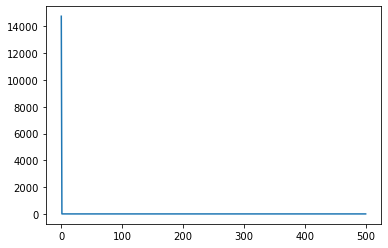

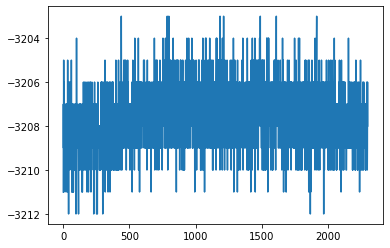

NameError: name 'z' is not defined

In [17]:
# from https://intellipaat.com/community/32125/plotting-a-fast-fourier-transform-in-python
from scipy import fft 

N = 1000 # Number of samplepoints 
T = 1.0 / N # sample spacing 
x = np.linspace(0.0, N*T, N) 

# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
temp = eeg_ptsa[0][0]
y = temp
filt80120 = temp.filtered([80,120],order=4,filt_type='bandpass')

yf = fft(y) 
xf = np.linspace(0.0, N/2, N/2) 
fig,ax = plt.subplots() 
ax.plot(xf, 2.0/N * np.abs(yf[:N//2])) 
plt.show()

plt.plot(y)
plt.show()
plt.plot(z)
plt.show()

fft_filt80120 = fft(filt80120)
NN = len(filt80120)
xff = np.linspace(0,NN/8,NN/2) # I think this is 4000 ms/500 SR to get 8
plt.plot(xff,8/NN*np.abs(fft_filt80120[:NN//2]))

## Example implementations of various filters being used (70/180 Hz hamming and 40 Hz kaiser)

In [18]:
from scipy.signal import kaiserord,firwin
from scipy import fft

FIR_bandpass = firwin(int(ntaps+1), [70.,180.], fs=desired_sample_rate, window='hamming',pass_zero='bandpass')
FIR_bandstop = firwin(int(ntaps+1), [70.,180.], fs=desired_sample_rate, window='hamming')

NN = eeg_ptsa.shape[2]
xr = np.linspace(0,NN/(4000/sr),NN/2) # 4000 ms of data/500 Hz sampling

## WHAT IS WRONG WITH EEG_RIP?? Nothing! Just hilbert+rectification ruins the bandpass in the FFT

# plot FFT of kaiser 40 hz lowpass
temp_rip = eeg_ptsa[0][0]-8650+1500
filt_temp_rip = filtfilt(kaiser_40lp_filter,1.,temp_rip)
plt.plot(filt_temp_rip); plt.show()
plt.plot(xr,normFFT(filt_temp_rip)); plt.show()

# plot FFT of rectified ripple eeg
temp_rip_band = eeg_rip_band.get_data()[0,0,:]
plt.plot(temp_rip_band); plt.show()
plt.plot(xr,normFFT(temp_rip_band)); plt.show()

# take single trial and filter using Norman FIR filter
temp_eeg = eeg_ptsa[0][0]+8650 # baseline subtracted trial of eeg
temp = filtfilt(FIR_bandpass,1.,temp_eeg)
plt.plot(temp); plt.show()
plt.plot(xr,normFFT(temp)); plt.show();
plt.plot(xr,normFFT(temp_eeg-filtfilt(FIR_bandstop,1.,temp_eeg))); plt.show()

NameError: name 'kaiser_40lp_filter' is not defined

## Single trial eeg viewer (load eeg_ptsa above via local run)

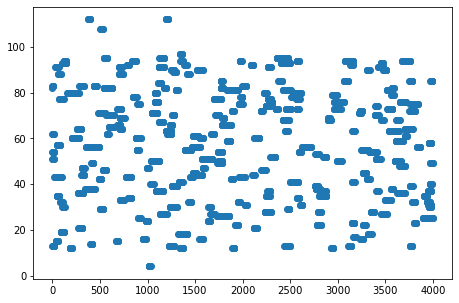

eeg_ptsa shape:
(113, 109, 2000)
Trial: 100, channel: 48


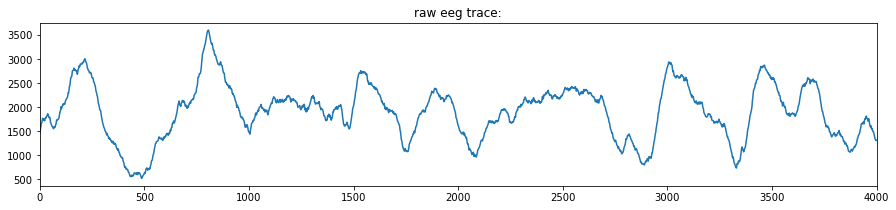

ValueError: The length of the input vector x must be greater than padlen, which is 2403.

In [771]:
from scipy.signal import kaiserord,firwin
from scipy import fft
from ptsa.data.filters import ButterworthFilter

# what ripple array looks like for given electrode/session
temp_array = ripple_array[0:113] #[405:486] #[880:900]
plt.figure(figsize=(plot_width/2, 5))
scatter(np.where(temp_array)[1],np.where(temp_array)[0])
xticks(np.arange(0,2001,250),np.arange(0,4001,500)); plt.show()

trial = 100
channel = 48 # 83

# setup params
bands = [70.,178.]
# FIR_bandpass = firwin(int(ntaps+1), bands, fs=sr, window='hamming',pass_zero='bandpass')
FIR_bandstop = firwin(int(ntaps+1), bands, fs=sr, window='hamming',pass_zero='bandstop')
FFT_xmax = 300
FFT_ymax = 20
xlimit = 4000
plot_width = 15

sr_factor = 1000/sr
temp_eeg_ptsa = eeg_ptsa[:,:,int(300/sr_factor):int(4300/sr_factor)] # remove buffers

print('eeg_ptsa shape:')
print(temp_eeg_ptsa.shape)
temp_rip = temp_eeg_ptsa[trial][channel] # get single trial
NN = temp_eeg_ptsa.shape[2]
xr = np.linspace(0,NN/(8000/1000),NN/2) # 4000 ms of data/500 Hz sampling

# plot raw eeg 
print('Trial: '+str(trial)+', '+'channel: '+str(channel))
xrange = np.arange(0,xlimit,sr_factor)
plt.figure(figsize=(plot_width, 3)); title('raw eeg trace:');
plt.plot(xrange,temp_rip); plt.xlim((0,xlimit)); plt.show()

# # filter out 120 Hz?
# eeg_120_removed = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
# eeg_180_removed = ButterworthFilter(timeseries=eeg_120_removed, freq_range=[178.,182.], filt_type='stop', order=4).filter()
# eeg_180_removed = eeg_180_removed[trial][channel]
# print('eeg 60 and 180 line removed')
# plt.plot(eeg_180_removed); plt.xlim((0,xlimit)); plt.show()
# print('FFT of eeg 60 and 180 removed')
# plt.plot(xr,normFFT(eeg_180_removed)); plt.xlim((0,FFT_xmax)); plt.ylim((0,FFT_ymax)); plt.show()

# take single trial and filter using Norman FIR filter
eeg_ptsa_trial = temp_eeg_ptsa[trial:trial+1] # grab desired trial 
filt_eeg_rip = eeg_ptsa_trial-filtfilt(FIR_bandstop,1.,eeg_ptsa_trial)
plt.figure(figsize=(plot_width, 3)); title('70-178 bandpass filtered:')
plt.plot(xrange,filt_eeg_rip[0][channel]); plt.xlim((0,xlimit)); plt.show()

# plot after taking hilbert
hilb_filt_eeg_rip = ptsa_to_mne(filt_eeg_rip,[0,4000])
_ = hilb_filt_eeg_rip.apply_hilbert(envelope=True)
plt.figure(figsize=(plot_width, 3)); title('Hilbert: ')
plt.plot(xrange,hilb_filt_eeg_rip.get_data()[0,channel,:]); 

# print('fft after bandpass (looks weird probably needs diff treatment)')
# N = int(len(temp_rip)/(1000/(bands[1]-bands[0])))
# fft_eeg = 1/N*np.abs(fft(temp_rip)[:N//2])
# x_fft = np.linspace(0,N/4,N/2)+70
# plt.plot(x_fft,fft_eeg); plt.xlim((0,FFT_xmax)); plt.ylim((0,20*FFT_ymax)); plt.show();

# plot FFT
plt.figure(figsize=(plot_width, 3)); title('FFT of this trial:');
plt.plot(xr,normFFT(temp_rip)); plt.xlim((0,FFT_xmax)); plt.ylim((0,FFT_ymax)); plt.show();
